# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Change path
## Set the path to where this notebook and the 'global_images' as well as 'global_annotations' are

In [ ]:
%cd "/content/drive/MyDrive/BracU/3. Spring2024/CSE428/Project/Milestone 2"

/content/drive/MyDrive/BracU/3. Spring2024/CSE428/Project/Milestone 2


# Imports

In [1]:
from pathlib import Path
import random
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os

# Global Files

In [ ]:
annotation_folder = Path("./global_annotations")
image_folder = Path("./global_images")

# Read file types

In [ ]:
annotation_files = {f.stem for f in Path(annotation_folder).iterdir()}
image_files = {f.stem for f in Path(image_folder).iterdir() if f.suffix.lower() in {'.jpg', '.jpeg', '.png'}}

matching_base_names = annotation_files.intersection(image_files)

matching_annotation_files = sorted([f.name for f in Path(annotation_folder).iterdir() if f.stem in matching_base_names])
matching_image_files = sorted([f.name for f in Path(image_folder).iterdir() if f.stem in matching_base_names])

print(f"Matching annotation files count {len(matching_annotation_files)}:", matching_annotation_files)
print(f"Matching image files count {len(matching_image_files)}:", matching_image_files)

Matching annotation files count 3758: ['1.txt', '10.txt', '1000.txt', '1001.txt', '1002.txt', '1003.txt', '1004.txt', '1005.txt', '1006.txt', '1007.txt', '1008.txt', '1009.txt', '1010.txt', '1011.txt', '1012.txt', '1013.txt', '1014.txt', '1015.txt', '1016.txt', '1017.txt', '1018.txt', '1019.txt', '1020.txt', '1021.txt', '1022.txt', '1023.txt', '1024.txt', '1025.txt', '1026.txt', '1027.txt', '1028.txt', '1029.txt', '1030.txt', '1031.txt', '1032.txt', '1033.txt', '1034.txt', '1035.txt', '1036.txt', '1037.txt', '1038.txt', '1039.txt', '1040.txt', '11.txt', '12.txt', '13.txt', '14.txt', '1441.txt', '1442.txt', '1443.txt', '1444.txt', '1445.txt', '1446.txt', '1447.txt', '1448.txt', '1449.txt', '1450.txt', '1451.txt', '1452.txt', '1453.txt', '1454.txt', '1455.txt', '1456.txt', '1457.txt', '1458.txt', '1459.txt', '1460.txt', '1461.txt', '1462.txt', '1463.txt', '1464.txt', '1465.txt', '1466.txt', '1467.txt', '1468.txt', '1469.txt', '1470.txt', '1471.txt', '1472.txt', '1473.txt', '1474.txt', '1

# Data List

In [ ]:
data = list(zip(matching_image_files, matching_annotation_files))

# Select your CSE428 Section & Project-Group

In [ ]:
# change section number and group number to generate csv files
section_number = 2
group_number = 1

seed = section_number*100+group_number
random.seed(seed)
random.shuffle(data)

total_size = len(data)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Data Split Sizes

In [ ]:
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 2630
Validation set size: 751
Test set size: 377


# Split list save

In [ ]:
train_df = pd.DataFrame(train_data, columns=['Train Images', 'Train Annotations'])
val_df = pd.DataFrame(val_data, columns=['Val Images', 'Val Annotations'])
test_df = pd.DataFrame(test_data, columns=['Test Images', 'Test Annotations'])

group_folder = Path(f"section{section_number}-group{group_number}")
group_folder.mkdir(parents=True, exist_ok=True)

# 3 csv files will be saved which you will dedicatedly use for your detection work
# The csv files will be inside a folder where your notebook is, named: 'sectionX-groupY'
train_df.to_csv(group_folder.joinpath("train.csv"), index=False)
val_df.to_csv(group_folder.joinpath("val.csv"), index=False)
test_df.to_csv(group_folder.joinpath("test.csv"), index=False)

# Importing torch and checking if cuda is available or not

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

# Visualizing Image From Train Dataset

In [ ]:
%cd "/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1"

/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1


In [ ]:
class_names=["SignBoard"]

colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=3
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(9, 7))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

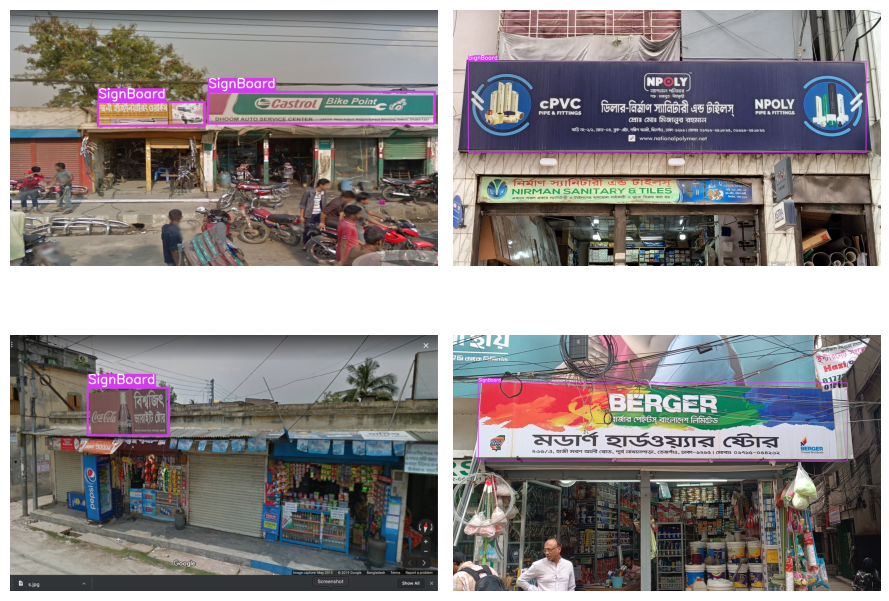

In [ ]:
plot(
    image_paths='train/images/*',
    label_paths='train/labels/*',
    num_samples=4,
)

# Writing Data.yaml file

In [ ]:
pwd

'/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1'

In [ ]:
%%writefile data.yaml
train: C:\Users\ASUS\section2-group1\train\images
val: val/images
test: test/images

nc: 1

# class names
names:
  0: 'SignBoard'


Overwriting data.yaml


# Installing Yolo V8

In [ ]:
!pip show ultralytics

Name: ultralytics
Version: 8.2.6
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: 
Author: Glenn Jocher, Ayush Chaurasia, Jing Qiu
Author-email: 
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 


In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 12.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

# Training

In [ ]:

from ultralytics import YOLO

# Create a new YOLO model from scratch
model = YOLO('yolov8s.yaml')

results = model.train(data='data.yaml', epochs=300, batch=32, imgsz=224, save=True, save_period=1,  pretrained=False,optimizer="Adam", val=True, verbose=True)

success = model.export()


New https://pypi.org/project/ultralytics/8.2.5 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=data.yaml, epochs=300, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning C:\Users\ASUS\section2-group1\train\labels.cache... 2630 images, 20 backgrounds, 0 corrupt: 100%|██████████| 2630/2630 [00:00<?, ?it/s]

train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_01.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_02.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_03.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_05.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_06.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_07.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_09.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_10.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASUS\section2-group1\train\images\19121070_11.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\ASU


val: Scanning C:\Users\ASUS\section2-group1\val\labels.cache... 751 images, 6 backgrounds, 0 corrupt: 100%|██████████| 751/751 [00:00<?, ?it/s]

val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_04.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_08.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_12.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_20.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_22.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_29.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\19121070_34.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\20101285_41.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\20101285_42.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\ASUS\section2-group1\val\images\20101285_

Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/83 [00:00<?, ?it/s]D:\anaconda\envs\CSE428Project\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/300      1.41G      3.934      2.698      2.694         18        224: 100%|██████████| 83/83 [00:48<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


                   all        751       1768    0.00453      0.299    0.00303   0.000858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      1.37G      2.405       1.92      1.796         22        224: 100%|██████████| 83/83 [00:52<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.309      0.355      0.241      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      1.39G      2.067      1.675      1.586         28        224: 100%|██████████| 83/83 [00:53<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768      0.208      0.253      0.138     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      1.37G       1.92      1.559      1.496         35        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

                   all        751       1768      0.375      0.408      0.303      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.39G      1.838      1.486      1.451         26        224: 100%|██████████| 83/83 [00:54<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.411      0.441      0.369      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      1.37G      1.774      1.435      1.417         37        224: 100%|██████████| 83/83 [00:55<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768       0.13      0.518      0.106     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      1.38G      1.702      1.378      1.379         30        224: 100%|██████████| 83/83 [00:56<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

                   all        751       1768      0.559      0.479      0.472      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      1.37G      1.694      1.355      1.373         21        224: 100%|██████████| 83/83 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.506      0.506      0.463      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      1.39G      1.615      1.271      1.323         31        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]

                   all        751       1768      0.567      0.563      0.534      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      1.36G      1.589      1.291      1.321         28        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


                   all        751       1768      0.614      0.559      0.572      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.39G      1.583      1.257      1.311         20        224: 100%|██████████| 83/83 [00:56<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

                   all        751       1768      0.543      0.534      0.509      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      1.37G      1.579      1.242      1.309         19        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]

                   all        751       1768      0.568      0.496      0.517      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      1.38G       1.55      1.225      1.287         28        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

                   all        751       1768      0.568      0.549      0.528      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.37G       1.53      1.234      1.288         21        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768      0.598      0.636      0.606      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      1.39G      1.544      1.228      1.291         23        224: 100%|██████████| 83/83 [00:53<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        751       1768      0.593      0.627        0.6      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      1.37G      1.525      1.224      1.272         26        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768      0.609      0.556      0.571      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      1.39G      1.491      1.184      1.259         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

                   all        751       1768      0.609      0.609      0.601      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      1.37G        1.5      1.177      1.262         35        224: 100%|██████████| 83/83 [00:56<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.583      0.624      0.606       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.38G       1.47      1.145       1.24         41        224: 100%|██████████| 83/83 [00:56<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.07s/it]

                   all        751       1768      0.596      0.636       0.61      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      1.37G      1.454      1.145       1.24         24        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

                   all        751       1768      0.539      0.568      0.508      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      1.38G      1.457      1.141      1.249         22        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]

                   all        751       1768      0.583      0.595      0.572      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      1.37G      1.453       1.14      1.242         12        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.612      0.628      0.608      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.38G      1.423      1.126      1.223         16        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.612      0.629      0.611      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      1.37G      1.436      1.117      1.225         27        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

                   all        751       1768      0.597      0.593      0.597      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.39G      1.416      1.124       1.22         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]

                   all        751       1768      0.605      0.636      0.612      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      1.37G      1.405      1.103      1.218         25        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.632      0.645      0.648      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.38G      1.401      1.104      1.212         31        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.618      0.652      0.632       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      1.37G       1.42      1.096      1.221         27        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768      0.622      0.637      0.634      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      1.39G      1.393      1.094      1.206         23        224: 100%|██████████| 83/83 [00:57<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768       0.64      0.624      0.641      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      1.36G      1.395      1.085      1.212         23        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.607      0.643      0.628      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.39G      1.369      1.091      1.193         38        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.645      0.656       0.66      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      1.37G      1.384      1.072        1.2         21        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]

                   all        751       1768      0.623      0.638      0.639      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.39G      1.355      1.059      1.188         23        224: 100%|██████████| 83/83 [00:55<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

                   all        751       1768      0.665      0.651      0.657      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      1.37G      1.388      1.077      1.204         42        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

                   all        751       1768      0.653      0.667      0.669      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      1.38G      1.372      1.059      1.196         34        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]

                   all        751       1768      0.662      0.669      0.671      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      1.36G      1.375      1.076        1.2         21        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.665      0.666       0.67      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      1.38G      1.333      1.042      1.178         30        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768       0.65      0.648      0.661      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.36G      1.334      1.035      1.174         38        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

                   all        751       1768      0.632      0.664      0.671      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      1.38G      1.344      1.045      1.189         23        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768      0.638      0.663      0.666      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      1.36G      1.346      1.049      1.183         33        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]

                   all        751       1768      0.635      0.673      0.661      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      1.39G      1.353      1.042      1.182         31        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.675      0.671      0.682      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      1.37G      1.327      1.013      1.177         23        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.635       0.65      0.662      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      1.38G       1.34      1.027      1.181         26        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]

                   all        751       1768      0.633      0.656      0.644      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      1.36G      1.334       1.02      1.177         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        751       1768      0.605      0.654      0.631      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      1.39G       1.32       1.02      1.176         37        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.653      0.667      0.679      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.37G      1.332      1.032      1.185         38        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]

                   all        751       1768      0.635      0.666      0.661      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      1.39G      1.323       1.03      1.168         33        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768       0.64      0.687      0.678      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      1.37G      1.321      1.012      1.182         27        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

                   all        751       1768      0.666       0.63      0.657      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.39G      1.315      1.025      1.169         22        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.652      0.687      0.688      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.37G      1.307      1.017      1.171         33        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768       0.64      0.669      0.667      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.38G      1.285     0.9999       1.16         29        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.677      0.663      0.683      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      1.37G      1.308     0.9966      1.164         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.663      0.678      0.696      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      1.39G      1.282     0.9826      1.153         32        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

                   all        751       1768      0.654      0.682       0.69      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      1.37G      1.295      0.999      1.162         28        224: 100%|██████████| 83/83 [00:55<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

                   all        751       1768      0.658      0.665      0.685      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      1.38G      1.294     0.9948      1.156         30        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768      0.652      0.687      0.689      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      1.37G      1.305     0.9829      1.156         32        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]

                   all        751       1768      0.671       0.67      0.691      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      1.38G      1.276     0.9775      1.157         21        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768       0.64      0.702      0.685      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      1.37G       1.27     0.9777      1.145         33        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all        751       1768      0.682      0.696      0.713      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.38G      1.283     0.9846      1.148         20        224: 100%|██████████| 83/83 [00:59<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.676      0.692      0.703      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.37G      1.285     0.9816      1.159         32        224: 100%|██████████| 83/83 [01:20<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.654      0.648      0.675        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      1.39G      1.282     0.9863      1.163         31        224: 100%|██████████| 83/83 [01:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.658      0.679      0.689      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      1.37G      1.295      1.009      1.159         24        224: 100%|██████████| 83/83 [01:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]

                   all        751       1768      0.673      0.688      0.706      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.38G       1.28     0.9758      1.149         19        224: 100%|██████████| 83/83 [01:42<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]

                   all        751       1768      0.654      0.673      0.678      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      1.37G      1.262     0.9594      1.142         23        224: 100%|██████████| 83/83 [01:22<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.672      0.666      0.688      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.38G      1.266     0.9619      1.144         23        224: 100%|██████████| 83/83 [01:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]

                   all        751       1768      0.674      0.701      0.708      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      1.37G      1.264      0.968       1.15         23        224: 100%|██████████| 83/83 [01:33<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768      0.673      0.658      0.692      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      1.38G      1.269     0.9773      1.147         34        224: 100%|██████████| 83/83 [01:29<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        751       1768      0.669      0.659      0.685      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      1.37G      1.274     0.9587      1.151         39        224: 100%|██████████| 83/83 [01:38<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.671      0.703       0.71      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.38G      1.266     0.9712      1.151         25        224: 100%|██████████| 83/83 [01:40<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]

                   all        751       1768      0.696      0.673      0.708      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      1.36G       1.26     0.9608      1.145         24        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all        751       1768      0.672      0.712      0.717      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      1.39G      1.245     0.9537      1.131         26        224: 100%|██████████| 83/83 [00:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]

                   all        751       1768      0.699      0.692      0.722      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      1.37G      1.247     0.9528      1.137         40        224: 100%|██████████| 83/83 [00:55<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]

                   all        751       1768      0.678      0.669      0.702      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      1.38G      1.255     0.9545      1.138         37        224: 100%|██████████| 83/83 [00:56<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.681      0.709      0.714      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      1.37G       1.25     0.9491      1.142         26        224: 100%|██████████| 83/83 [00:55<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.698       0.68      0.717      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      1.38G      1.237     0.9468      1.135         21        224: 100%|██████████| 83/83 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.659      0.688      0.697      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      1.37G      1.261     0.9471      1.152         30        224: 100%|██████████| 83/83 [00:56<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768      0.684      0.663      0.697       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      1.38G       1.25     0.9592      1.138         32        224: 100%|██████████| 83/83 [00:55<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]

                   all        751       1768       0.68      0.703      0.713      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      1.36G      1.238     0.9425      1.131         33        224: 100%|██████████| 83/83 [00:50<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        751       1768      0.677      0.711       0.72      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      1.38G      1.235     0.9463      1.124         21        224: 100%|██████████| 83/83 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.677      0.676      0.703       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      1.37G      1.227     0.9338      1.125         42        224: 100%|██████████| 83/83 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]

                   all        751       1768      0.708      0.704      0.731      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      1.39G      1.228     0.9198      1.131         31        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768      0.677      0.688      0.711      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      1.36G      1.245      0.938      1.139         32        224: 100%|██████████| 83/83 [00:54<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]

                   all        751       1768       0.69      0.699      0.716      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      1.38G      1.218     0.9306       1.13         28        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

                   all        751       1768      0.666      0.678      0.694      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      1.37G      1.212     0.9281      1.125         25        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.697      0.702      0.716      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      1.38G      1.233     0.9325      1.126         21        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        751       1768      0.696      0.676      0.714      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.36G      1.209     0.9308      1.116         11        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.688      0.705      0.725      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      1.39G      1.231     0.9355      1.123         41        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.666      0.693      0.705      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      1.36G      1.201     0.9149       1.12         19        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.704      0.701      0.732      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      1.39G      1.223     0.9249      1.119         48        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.684      0.718      0.717      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.37G      1.229     0.9203      1.127         18        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]

                   all        751       1768      0.699      0.664        0.7      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.39G      1.216     0.9166      1.133         31        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.676      0.716      0.716      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      1.36G      1.207     0.9127      1.115         45        224: 100%|██████████| 83/83 [01:06<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        751       1768      0.714      0.688      0.733      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.38G      1.203     0.9144       1.12         26        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768       0.68      0.691      0.712      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      1.37G      1.198     0.9042      1.108         36        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.689      0.706      0.729      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      1.38G       1.21     0.9085      1.121         22        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]

                   all        751       1768      0.704       0.69      0.721      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.37G      1.227     0.9204      1.122         47        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.709      0.696      0.728      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      1.38G      1.203     0.9075      1.119         27        224: 100%|██████████| 83/83 [00:57<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.697      0.696      0.725      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.37G      1.208     0.9061      1.127         38        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

                   all        751       1768      0.693      0.732      0.735      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      1.38G      1.199     0.9121      1.112         26        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.689       0.68      0.717       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      1.37G      1.194     0.8996      1.116         24        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.689      0.695      0.721      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      1.38G      1.209     0.9149      1.118         21        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        751       1768      0.676      0.686      0.717      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      1.36G      1.188     0.8918      1.108         22        224: 100%|██████████| 83/83 [01:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.682      0.699      0.727      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      1.39G      1.185     0.9038      1.113         44        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

                   all        751       1768      0.699      0.701      0.732      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      1.37G      1.197     0.9026      1.112         28        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.701      0.703      0.724      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      1.38G      1.202     0.9047       1.12         22        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.704      0.697      0.731      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      1.37G      1.175     0.8904      1.106         26        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        751       1768      0.663      0.705      0.721      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      1.39G      1.189     0.8972      1.103         48        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        751       1768      0.678       0.73      0.734       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      1.37G      1.191     0.8932      1.106         23        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

                   all        751       1768      0.726      0.686      0.742       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      1.38G      1.185     0.8814      1.101         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        751       1768      0.689      0.696      0.721      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      1.37G      1.189     0.8877      1.108         27        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.696      0.713      0.728       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      1.38G      1.164     0.8812      1.102         20        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.705      0.703       0.73       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      1.36G      1.183     0.8837      1.104         30        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768      0.711        0.7      0.743       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      1.38G      1.173     0.8934        1.1         20        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        751       1768      0.682      0.725      0.744      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      1.36G      1.178     0.8819      1.105         21        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768      0.683      0.724      0.738      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      1.38G      1.175     0.8743        1.1         25        224: 100%|██████████| 83/83 [00:57<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.709      0.708      0.741      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      1.37G      1.183     0.8825      1.106         26        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]

                   all        751       1768      0.701      0.722      0.744      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      1.39G      1.187     0.8901      1.114         16        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768        0.7       0.71      0.745      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.37G      1.181     0.8934      1.111         24        224: 100%|██████████| 83/83 [01:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768        0.7      0.726      0.735      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      1.38G      1.168     0.8784        1.1         34        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768      0.683      0.718      0.733      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      1.37G      1.154     0.8655      1.098         27        224: 100%|██████████| 83/83 [01:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.702      0.688      0.734      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      1.39G      1.171     0.8755      1.116         21        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        751       1768      0.691      0.719      0.736      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.37G      1.179     0.8762      1.094         27        224: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.685      0.721      0.731      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      1.38G      1.183     0.8785      1.104         48        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        751       1768      0.698      0.713      0.737      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      1.36G      1.156     0.8642      1.097         40        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

                   all        751       1768      0.673      0.725      0.738      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      1.39G      1.173     0.8713      1.093         24        224: 100%|██████████| 83/83 [01:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all        751       1768      0.684      0.721      0.742       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      1.37G       1.17     0.8731      1.094         30        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.707      0.715      0.745      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      1.38G       1.16     0.8612      1.088         16        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

                   all        751       1768      0.704      0.726      0.741      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      1.37G      1.151     0.8589       1.09         31        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all        751       1768      0.682      0.739      0.739      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      1.39G      1.169     0.8638      1.096         15        224: 100%|██████████| 83/83 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]

                   all        751       1768      0.696      0.721      0.745      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      1.37G      1.162     0.8602      1.097         40        224: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

                   all        751       1768      0.709      0.713      0.749      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      1.38G      1.159     0.8638      1.101         38        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768       0.68      0.727      0.738      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      1.36G      1.168     0.8867      1.101         14        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.688       0.73      0.737      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      1.38G      1.161     0.8722      1.092         24        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.694      0.721      0.748      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      1.37G      1.158     0.8684      1.101         28        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]

                   all        751       1768      0.685      0.734      0.741      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      1.38G      1.173     0.8645      1.098         28        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]

                   all        751       1768      0.686      0.726      0.739      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      1.36G      1.147     0.8559      1.087         24        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.673      0.737      0.741      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      1.38G      1.168     0.8737        1.1         37        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

                   all        751       1768      0.695      0.738      0.746      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      1.36G      1.172     0.8762      1.104         37        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        751       1768        0.7      0.717      0.737      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      1.39G      1.142     0.8605      1.087         25        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.694      0.732       0.74      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      1.36G      1.158     0.8649      1.098         38        224: 100%|██████████| 83/83 [00:59<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.706      0.718      0.739      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      1.38G      1.141      0.843      1.093         26        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        751       1768      0.695      0.732      0.743      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      1.36G      1.139     0.8484      1.092         33        224: 100%|██████████| 83/83 [00:57<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

                   all        751       1768      0.696      0.741      0.754      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      1.38G      1.145     0.8459      1.084         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

                   all        751       1768      0.711      0.733      0.753      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      1.35G       1.14     0.8443      1.086         23        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768      0.717      0.732      0.756      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      1.38G      1.147     0.8509      1.084         38        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

                   all        751       1768      0.694      0.742      0.749      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      1.37G      1.142     0.8392      1.084         21        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

                   all        751       1768      0.696      0.727      0.747      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      1.39G      1.153     0.8536      1.092         24        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]

                   all        751       1768      0.712      0.721      0.749      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      1.37G      1.128     0.8459      1.078         31        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        751       1768      0.716      0.734      0.755      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      1.38G      1.141     0.8452      1.094         19        224: 100%|██████████| 83/83 [00:56<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.701      0.731      0.746      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      1.37G      1.145     0.8417      1.083         36        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]

                   all        751       1768      0.711      0.712      0.745      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      1.38G      1.136     0.8382      1.086         37        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.694      0.727      0.749      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      1.36G      1.136     0.8394      1.085         25        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.719      0.713      0.755      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      1.39G      1.143     0.8377      1.085         44        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.691      0.735       0.75      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      1.37G      1.133     0.8375      1.085         31        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.692      0.728      0.743      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      1.39G      1.148     0.8315      1.086         22        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

                   all        751       1768      0.699      0.735      0.752      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      1.37G      1.142     0.8401      1.084         28        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768      0.705      0.721      0.751      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      1.39G      1.125      0.832      1.074         34        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

                   all        751       1768      0.696      0.717      0.746      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      1.36G      1.124      0.819      1.081         26        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]

                   all        751       1768       0.69      0.735      0.744       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      1.38G       1.14     0.8452      1.086         35        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.684       0.74       0.75      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      1.36G      1.118     0.8243       1.08         31        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

                   all        751       1768      0.692      0.738      0.755      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      1.38G      1.121     0.8276      1.073         33        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        751       1768      0.703      0.729      0.751      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      1.36G      1.128     0.8333      1.074         28        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

                   all        751       1768      0.698      0.734      0.753      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      1.38G      1.149     0.8361      1.082         25        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.33it/s]

                   all        751       1768      0.693      0.731      0.752      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      1.37G      1.106     0.8185      1.069         25        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.07s/it]

                   all        751       1768      0.702      0.734      0.753      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      1.39G      1.111     0.8161       1.07         18        224: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.717      0.725      0.753      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      1.36G      1.108     0.8256      1.075         28        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        751       1768      0.707      0.734      0.751      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      1.38G      1.124     0.8221      1.078         29        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768      0.721      0.716       0.75      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      1.36G      1.129     0.8196      1.082         22        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.695      0.735      0.745      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      1.39G      1.117     0.8268      1.073         21        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

                   all        751       1768      0.695      0.725      0.749      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      1.36G      1.104     0.8217      1.069         18        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]

                   all        751       1768      0.705      0.723      0.754      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      1.39G      1.117     0.8181      1.069         38        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.699      0.718       0.75      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      1.37G       1.12     0.8232       1.08         32        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

                   all        751       1768      0.694      0.734      0.751      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      1.38G      1.103     0.8156      1.078         25        224: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.699      0.733      0.755      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      1.37G      1.083     0.8018      1.057         22        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]

                   all        751       1768      0.705       0.73      0.753      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      1.38G      1.109     0.8071      1.071         34        224: 100%|██████████| 83/83 [00:59<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        751       1768      0.707      0.727      0.753      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      1.36G      1.106     0.8048      1.067         30        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]

                   all        751       1768      0.726      0.702       0.75      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      1.38G        1.1     0.8136      1.076         21        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768        0.7      0.723      0.752      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      1.37G      1.103     0.8012      1.067         37        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.697      0.729      0.748      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      1.38G      1.098      0.797       1.07         34        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.703      0.717      0.739      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      1.37G      1.106     0.8088      1.067         31        224: 100%|██████████| 83/83 [01:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

                   all        751       1768      0.699      0.723      0.742      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      1.38G      1.101     0.8063      1.067         51        224: 100%|██████████| 83/83 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]

                   all        751       1768      0.703      0.723      0.746       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      1.36G       1.09     0.7943      1.068         24        224: 100%|██████████| 83/83 [01:23<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

                   all        751       1768      0.708      0.722       0.75      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      1.38G      1.118     0.8011      1.074         19        224: 100%|██████████| 83/83 [01:26<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

                   all        751       1768      0.692      0.735      0.748      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      1.37G      1.091     0.7985      1.064         22        224: 100%|██████████| 83/83 [01:14<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

                   all        751       1768      0.707      0.725      0.751      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      1.38G       1.11     0.8171      1.069         25        224: 100%|██████████| 83/83 [01:26<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]

                   all        751       1768      0.684      0.748      0.755      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      1.37G      1.087      0.794      1.066         31        224: 100%|██████████| 83/83 [01:38<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        751       1768      0.697      0.727      0.752      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      1.38G      1.121     0.8019      1.071         20        224: 100%|██████████| 83/83 [01:14<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.689      0.743      0.753      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      1.37G      1.103     0.8077      1.068         45        224: 100%|██████████| 83/83 [01:25<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]

                   all        751       1768      0.692      0.737       0.75      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      1.39G      1.104     0.8056       1.07         38        224: 100%|██████████| 83/83 [00:51<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]

                   all        751       1768       0.69      0.741      0.752      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      1.37G      1.101     0.7943      1.066         28        224: 100%|██████████| 83/83 [00:52<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

                   all        751       1768      0.695      0.725      0.751      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      1.38G      1.091        0.8       1.08         30        224: 100%|██████████| 83/83 [00:55<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

                   all        751       1768      0.721      0.706      0.753      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      1.37G      1.089     0.8021      1.059         30        224: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

                   all        751       1768      0.724      0.708      0.751      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      1.38G      1.099     0.7953      1.063         36        224: 100%|██████████| 83/83 [00:57<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768      0.706      0.722      0.749      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      1.37G      1.102     0.8089      1.069         33        224: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.689      0.744       0.75      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      1.38G       1.08     0.7938      1.057         24        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]

                   all        751       1768        0.7      0.741      0.749      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      1.37G      1.086     0.8021       1.05         36        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768      0.702       0.74       0.75      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      1.38G      1.082     0.7905      1.062         23        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.696       0.75      0.752        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      1.36G      1.091     0.7849       1.07         31        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.705      0.742      0.753      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      1.38G       1.09     0.7875      1.059         20        224: 100%|██████████| 83/83 [00:56<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.709       0.74      0.754        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      1.37G      1.093     0.7856      1.064         40        224: 100%|██████████| 83/83 [00:59<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.703      0.737      0.752        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      1.39G      1.079     0.7813      1.058         37        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.697      0.747      0.754      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      1.37G      1.092      0.786      1.065         45        224: 100%|██████████| 83/83 [00:55<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.07s/it]

                   all        751       1768      0.692      0.747      0.754      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      1.38G      1.083       0.79      1.063         19        224: 100%|██████████| 83/83 [01:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all        751       1768      0.707      0.726      0.753      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      1.36G      1.081     0.7886       1.06         24        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.706      0.719      0.751      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      1.38G      1.068     0.7803      1.053         34        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        751       1768      0.703      0.732      0.756      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      1.37G      1.083     0.7932      1.062         26        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

                   all        751       1768      0.712      0.722      0.754      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      1.38G      1.081     0.7815       1.06         29        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.701       0.74      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      1.37G      1.086     0.7791      1.061         23        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.693      0.746      0.756      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      1.38G      1.074     0.7823      1.057         38        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

                   all        751       1768      0.707      0.736      0.754      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      1.37G      1.079     0.7829      1.063         29        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]

                   all        751       1768      0.706      0.741      0.755      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      1.38G      1.067     0.7746      1.057         24        224: 100%|██████████| 83/83 [01:04<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

                   all        751       1768      0.703      0.732      0.756      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      1.37G      1.065     0.7744      1.055         29        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768      0.721      0.723      0.755      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      1.38G       1.06     0.7757      1.049         24        224: 100%|██████████| 83/83 [00:57<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        751       1768      0.704      0.731      0.754      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      1.36G      1.066     0.7649      1.055         27        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        751       1768      0.701      0.739      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      1.38G      1.059     0.7637      1.042         25        224: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.703      0.742      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      1.36G      1.056     0.7676      1.048         12        224: 100%|██████████| 83/83 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]

                   all        751       1768        0.7      0.744      0.758      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      1.39G       1.07       0.77      1.054         30        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]

                   all        751       1768      0.696      0.743      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      1.37G      1.053     0.7613      1.043         37        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

                   all        751       1768      0.693       0.75      0.759      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      1.39G      1.063     0.7571      1.048         24        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]

                   all        751       1768      0.715      0.729      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      1.36G      1.055     0.7652      1.051         37        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.708      0.742      0.759      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      1.38G      1.056       0.77      1.057         20        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768      0.709      0.745      0.754      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      1.37G      1.058     0.7499      1.046         27        224: 100%|██████████| 83/83 [01:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.709      0.741      0.755      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      1.38G      1.061     0.7626      1.046         27        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.712      0.734      0.754      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      1.36G      1.043     0.7522      1.045         38        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.712      0.731      0.753      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      1.38G      1.053     0.7619      1.043         34        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.713      0.725      0.758      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      1.36G      1.063     0.7617      1.052         25        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.717      0.732      0.758      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      1.38G      1.049     0.7569      1.044         28        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]

                   all        751       1768      0.685      0.749      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      1.37G      1.051     0.7612      1.044         29        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]

                   all        751       1768      0.681      0.775      0.759      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      1.39G      1.056     0.7498      1.052         28        224: 100%|██████████| 83/83 [01:05<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

                   all        751       1768       0.68      0.767      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      1.37G      1.054     0.7494      1.039         40        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]

                   all        751       1768      0.686      0.761      0.758      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      1.38G      1.038      0.747       1.04         27        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        751       1768      0.682       0.77      0.753      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      1.37G      1.056     0.7587      1.046         36        224: 100%|██████████| 83/83 [01:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]

                   all        751       1768      0.675      0.772      0.753      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      1.39G      1.036     0.7542      1.043         18        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.675      0.773      0.753      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      1.37G      1.045     0.7504      1.048         34        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]

                   all        751       1768      0.679      0.769      0.756      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      1.38G      1.047     0.7543      1.042         29        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.692      0.748      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      1.37G      1.038     0.7609      1.043         27        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.694      0.751      0.755      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      1.38G      1.042     0.7589       1.04         41        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]

                   all        751       1768      0.704      0.741      0.758      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      1.37G      1.033     0.7459      1.037         31        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.718      0.736      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      1.37G      1.045     0.7454      1.036         29        224: 100%|██████████| 83/83 [01:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768       0.72      0.736       0.76      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      1.36G      1.048     0.7462      1.038         34        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.709      0.744      0.759      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      1.38G      1.023     0.7416      1.032         19        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.712       0.74      0.761      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      1.37G      1.035     0.7431      1.043         29        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]

                   all        751       1768      0.694      0.749      0.758      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      1.38G      1.036     0.7458      1.041         30        224: 100%|██████████| 83/83 [00:58<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        751       1768      0.692      0.756       0.76      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      1.37G      1.028     0.7399      1.028         28        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]

                   all        751       1768      0.691      0.759      0.759      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      1.38G       1.02     0.7348      1.039         21        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.703      0.749      0.761      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      1.37G      1.042     0.7388      1.039         32        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

                   all        751       1768      0.698      0.748      0.761      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      1.38G      1.028     0.7319      1.039         26        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]

                   all        751       1768      0.702      0.748       0.76      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      1.37G      1.021     0.7293       1.03         33        224: 100%|██████████| 83/83 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]

                   all        751       1768      0.706      0.747      0.762      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      1.39G      1.018     0.7256      1.023         13        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.705      0.752      0.762      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      1.37G      1.012     0.7292      1.028         40        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.703      0.755      0.762      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      1.38G      1.015     0.7345      1.025         43        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

                   all        751       1768      0.701      0.755      0.762      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      1.36G      1.005     0.7141      1.025         29        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.702      0.747       0.76      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      1.39G      1.009     0.7181      1.025         27        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.727      0.723      0.761      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      1.37G      1.019     0.7244      1.026         34        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]

                   all        751       1768      0.725      0.723      0.759      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      1.39G      1.015     0.7229      1.026         39        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

                   all        751       1768      0.718       0.73      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      1.36G      1.013     0.7233       1.03         29        224: 100%|██████████| 83/83 [00:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]

                   all        751       1768      0.715      0.735      0.758      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      1.38G      1.005     0.7082      1.027         27        224: 100%|██████████| 83/83 [01:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.709      0.733      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      1.37G      1.015     0.7305      1.023         35        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]

                   all        751       1768      0.718      0.729      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      1.39G      1.008     0.7207      1.032         23        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768      0.718      0.717      0.756      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      1.37G      1.017     0.7236      1.025         25        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.08s/it]

                   all        751       1768      0.722      0.718      0.761      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      1.38G      1.023     0.7278      1.028         22        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

                   all        751       1768      0.718      0.721      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      1.36G      1.008     0.7167      1.031         32        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

                   all        751       1768       0.72       0.72      0.756      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      1.38G     0.9962      0.713       1.02         20        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.715      0.728      0.755      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      1.37G     0.9957     0.7109      1.018         35        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768      0.722      0.717      0.755      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      1.38G     0.9961     0.7079      1.017         22        224: 100%|██████████| 83/83 [01:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768       0.72      0.719      0.756      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      1.37G      1.002     0.7154      1.018         42        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

                   all        751       1768      0.725      0.714      0.756      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      1.38G      1.004      0.708      1.019         19        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]

                   all        751       1768      0.724      0.715      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      1.37G      1.008     0.7196      1.027         35        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

                   all        751       1768       0.73      0.712      0.755      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      1.38G     0.9978     0.7063      1.023         34        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

                   all        751       1768      0.718      0.724      0.755      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      1.37G     0.9877     0.7006      1.014         38        224: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        751       1768      0.715      0.729      0.756      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      1.38G     0.9847     0.7076      1.021         28        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.08s/it]

                   all        751       1768      0.714      0.729      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      1.36G      1.006     0.7184      1.019         29        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]

                   all        751       1768      0.719      0.722      0.756      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      1.38G      0.995     0.7136      1.016         33        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

                   all        751       1768      0.703      0.732      0.755      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      1.36G     0.9864     0.7081      1.016         15        224: 100%|██████████| 83/83 [01:04<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]

                   all        751       1768        0.7      0.738      0.757      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      1.38G     0.9954     0.7084      1.019         43        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

                   all        751       1768      0.702      0.737      0.757      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      1.37G     0.9863     0.7027      1.018         22        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

                   all        751       1768      0.707      0.734      0.757      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      1.38G     0.9786      0.699      1.008         24        224: 100%|██████████| 83/83 [01:02<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.706      0.736      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      1.37G     0.9829     0.7031      1.019         29        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        751       1768      0.708       0.73      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      1.38G     0.9868      0.698      1.015         32        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768       0.71      0.729      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      1.36G     0.9989     0.7088      1.013         42        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]

                   all        751       1768        0.7      0.744      0.756      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      1.39G     0.9836     0.6989      1.014         39        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

                   all        751       1768      0.693      0.754      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      1.37G      0.992     0.7018      1.016         32        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

                   all        751       1768      0.692      0.754      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      1.38G     0.9776     0.6979      1.007         29        224: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        751       1768      0.695       0.74      0.755      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      1.37G      0.985      0.699      1.014         32        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.705      0.731      0.754      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      1.39G     0.9774     0.6898      1.011         19        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

                   all        751       1768      0.701      0.731      0.753      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      1.37G     0.9759     0.6907      1.006         30        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768       0.71      0.727      0.753      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      1.38G     0.9676     0.6812      1.008         37        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

                   all        751       1768       0.71      0.725      0.754      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      1.37G     0.9792     0.6897      1.011         29        224: 100%|██████████| 83/83 [00:58<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

                   all        751       1768      0.713      0.724      0.753      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      1.38G      0.978     0.6872      1.005         31        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

                   all        751       1768      0.733      0.704      0.753      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      1.37G     0.9493      0.688      1.001         20        224: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]

                   all        751       1768      0.736        0.7      0.753      0.502


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      1.38G     0.9751     0.7448      1.024          7        224: 100%|██████████| 83/83 [00:54<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]

                   all        751       1768      0.741      0.697      0.754      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      1.36G     0.9426     0.6829      1.006          8        224: 100%|██████████| 83/83 [00:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

                   all        751       1768      0.739      0.701      0.754      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      1.38G     0.9355     0.6737      1.004         14        224: 100%|██████████| 83/83 [00:58<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

                   all        751       1768      0.735      0.703      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      1.37G     0.9304      0.671      1.004         12        224: 100%|██████████| 83/83 [01:02<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768      0.733      0.704      0.752      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      1.38G     0.9216     0.6707     0.9954         28        224: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

                   all        751       1768       0.71       0.73      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      1.36G     0.9224     0.6607      1.001         11        224: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768      0.712       0.73      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      1.38G     0.9158     0.6518     0.9979          8        224: 100%|██████████| 83/83 [01:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

                   all        751       1768      0.714      0.731      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      1.37G     0.9198     0.6611     0.9943         32        224: 100%|██████████| 83/83 [01:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]

                   all        751       1768      0.707      0.739      0.759      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      1.38G     0.9143     0.6582     0.9884          7        224: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        751       1768      0.705      0.739      0.759      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      1.37G      0.916     0.6539     0.9861         13        224: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        751       1768      0.738      0.705      0.759      0.519



300 epochs completed in 6.187 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 22.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


D:\anaconda\envs\CSE428Project\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


                   all        751       1768      0.711      0.736       0.76      0.519
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train2
Ultralytics YOLOv8.2.2  Python-3.11.9 torch-2.3.0+cu121 CPU (Intel Core(TM) i5-8300H 2.30GHz)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs\detect\train2\weights\best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 5, 1029) (21.5 MB)

TorchScript: starting export with torch 2.3.0+cu121...
TorchScript: export success  3.8s, saved as 'runs\detect\train2\weights\best.torchscript' (42.8 MB)

Export complete (6.9s)
Results saved to C:\Users\ASUS\section2-group1\runs\detect\train2\weights
Predict:         yolo predict task=detect model=runs\detect\train2\weights\best.torchscript imgsz=224  
Validate:        yolo val task=detect model=runs\detect\train2\weights\best.torchscript imgsz=224 data=data.yaml  


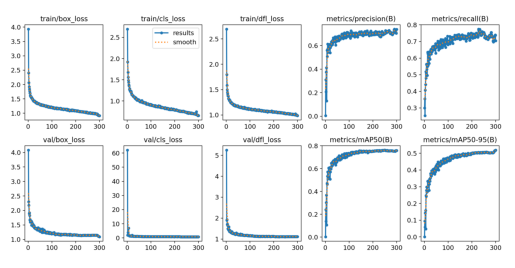

In [ ]:
import matplotlib.image as mpimg
metric_path = 'runs/detect/train2/results.png'

# Loading the image
img = mpimg.imread(metric_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

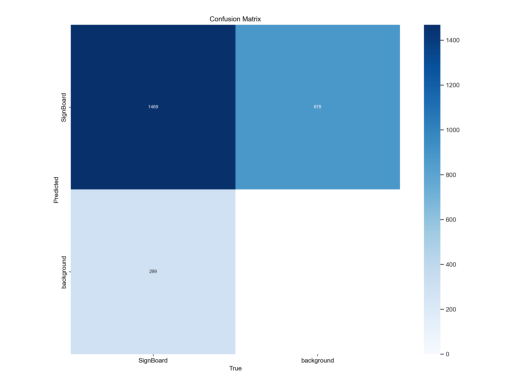

In [ ]:
conf_path = 'runs/detect/train2/confusion_matrix.png'

# Loading the image
img = mpimg.imread(conf_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

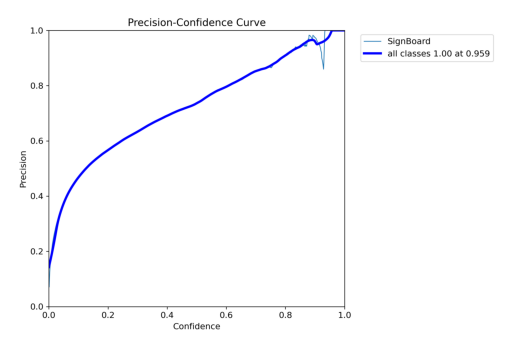

In [ ]:
pcurve_path = 'runs/detect/train2/P_curve.png'

# Loading the image
img = mpimg.imread(pcurve_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

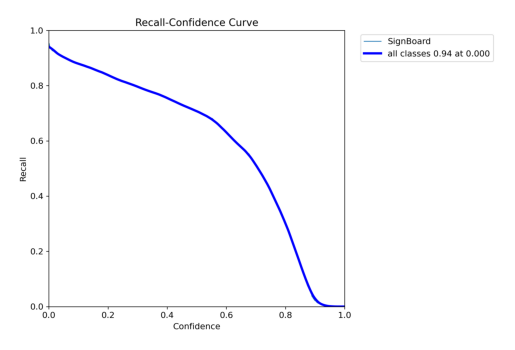

In [ ]:
rcurve_path = 'runs/detect/train2/R_curve.png'

# Loading the image
img = mpimg.imread(rcurve_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

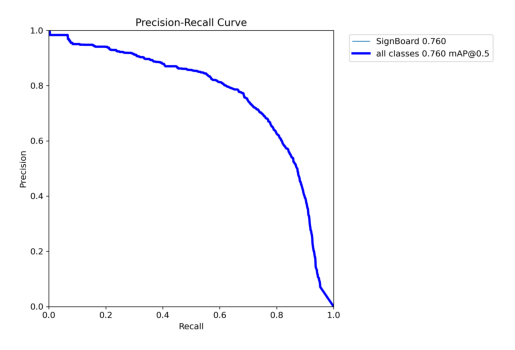

In [ ]:
pr_path = 'runs/detect/train2/PR_curve.png'

# Loading the image
img = mpimg.imread(pr_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

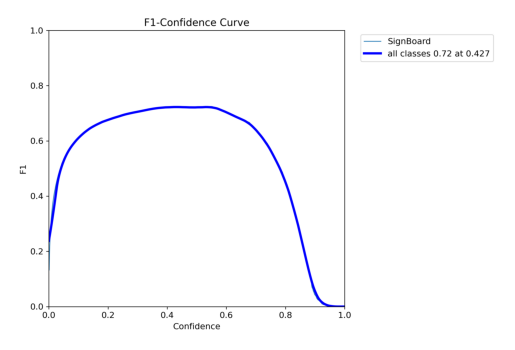

In [ ]:
f1_path = 'runs/detect/train2/F1_curve.png'

# Loading the image
img = mpimg.imread(f1_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

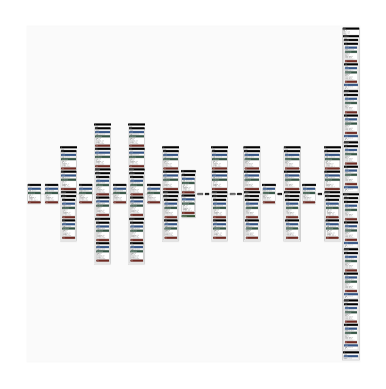

In [ ]:
bmodel_path = 'best.pt.png'

# Loading the image
img = mpimg.imread(bmodel_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Validating the Model

In [ ]:
#validating the model
from ultralytics import YOLO
model = YOLO('runs/detect/train2/weights/best.pt')
results = model.val(data='/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/data.yaml',imgsz=544,batch=1,   ,save_json=True, plots=True)



Ultralytics YOLOv8.2.7 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 26.6MB/s]
val: Scanning /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/labels.cache... 751 images, 6 backgrounds, 0 corrupt: 100%|██████████| 751/751 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_04.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_08.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_12.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_20.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_22.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_29.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/val/images/19121070_34.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/drive/MyDrive/CSE428/Milestone2/Section2-Gro


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 751/751 [02:16<00:00,  5.49it/s]


                   all        751       1768      0.604      0.674      0.637      0.438
Speed: 0.7ms preprocess, 22.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val


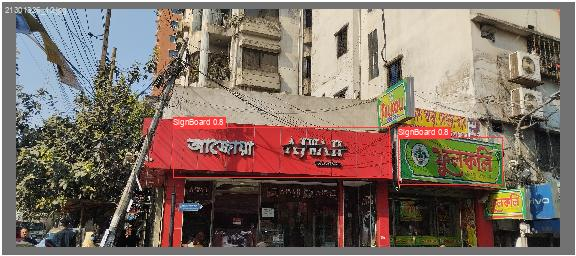

In [ ]:
from IPython.display import Image
img_path = 'runs/detect/val/val_batch0_pred.jpg'

# Display the image
Image(img_path)

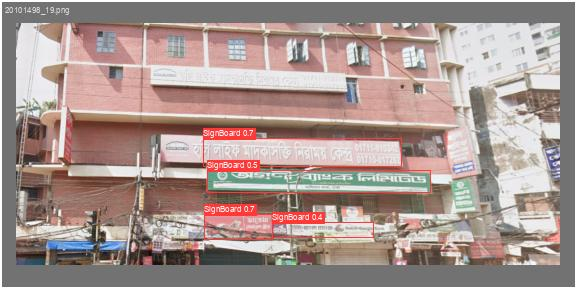

In [ ]:
img_path = 'runs/detect/val/val_batch1_pred.jpg'

# Display the image
Image(img_path)

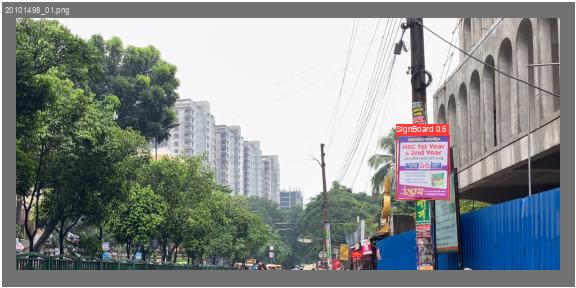

In [ ]:
img_path = 'runs/detect/val/val_batch2_pred.jpg'

# Display the image
Image(img_path)

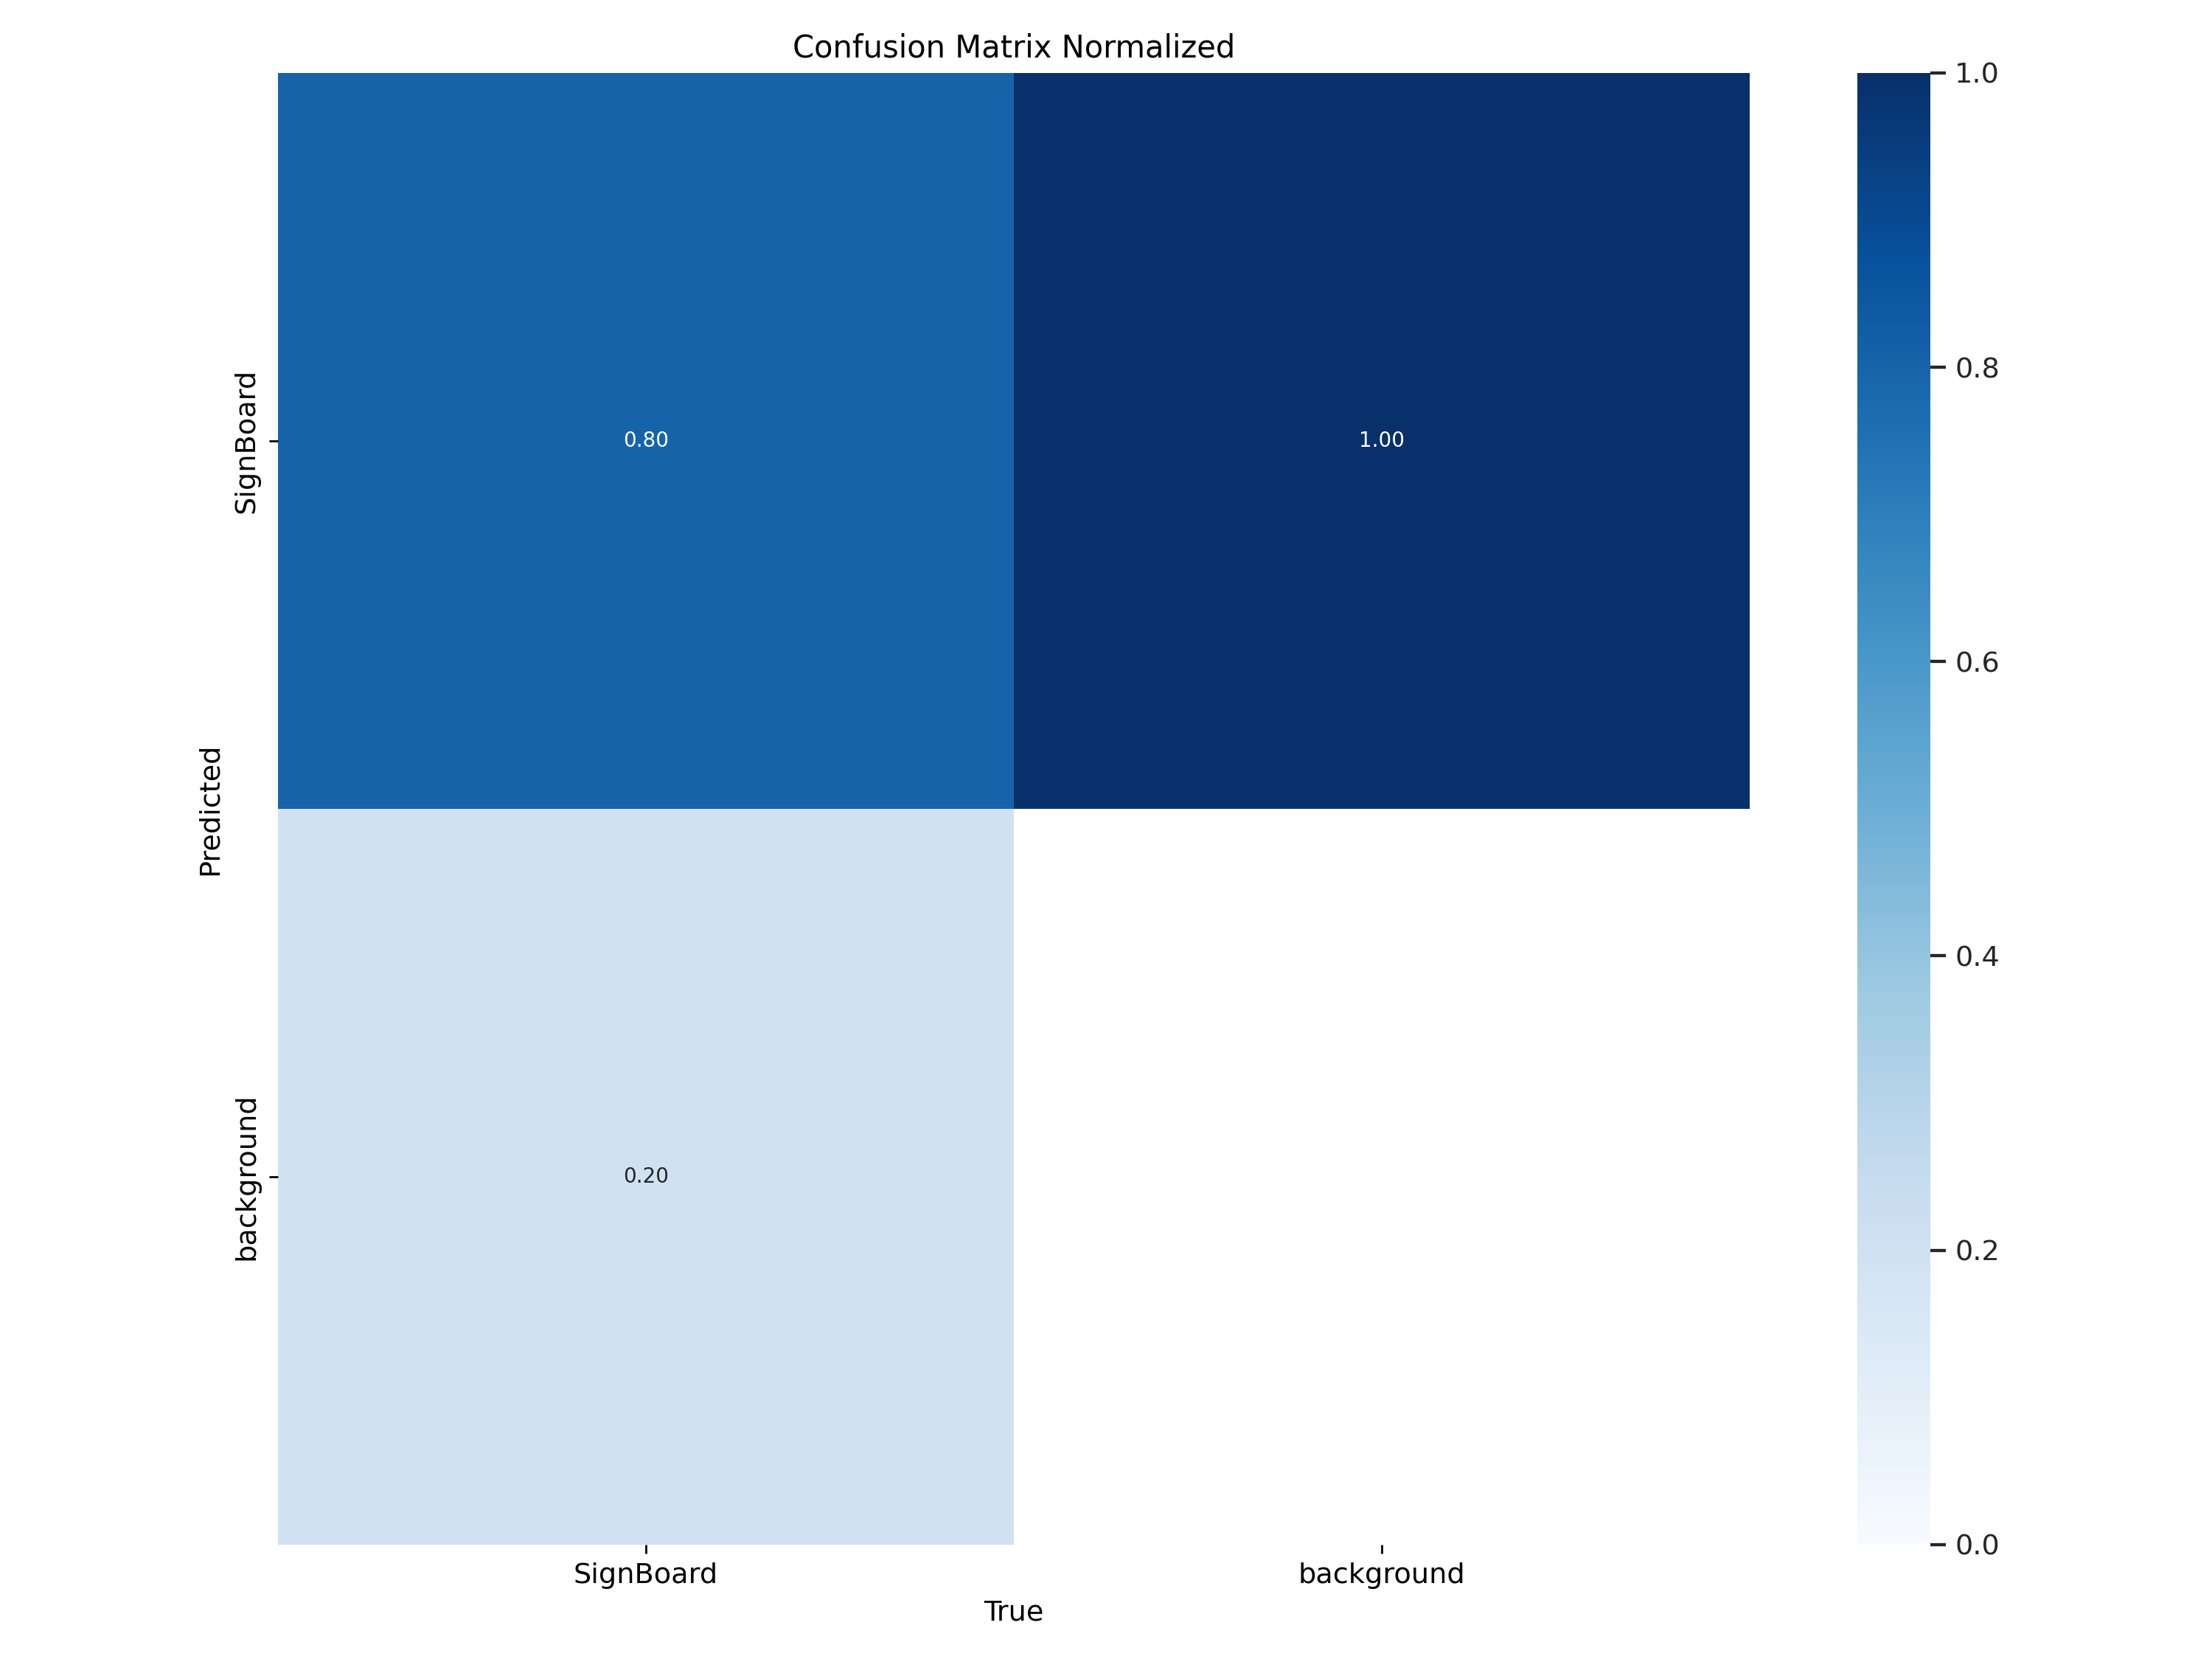

In [ ]:
img_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/val/confusion_matrix_normalized.png'

# Display the image
Image(filename=img_path,width=600,height=600)

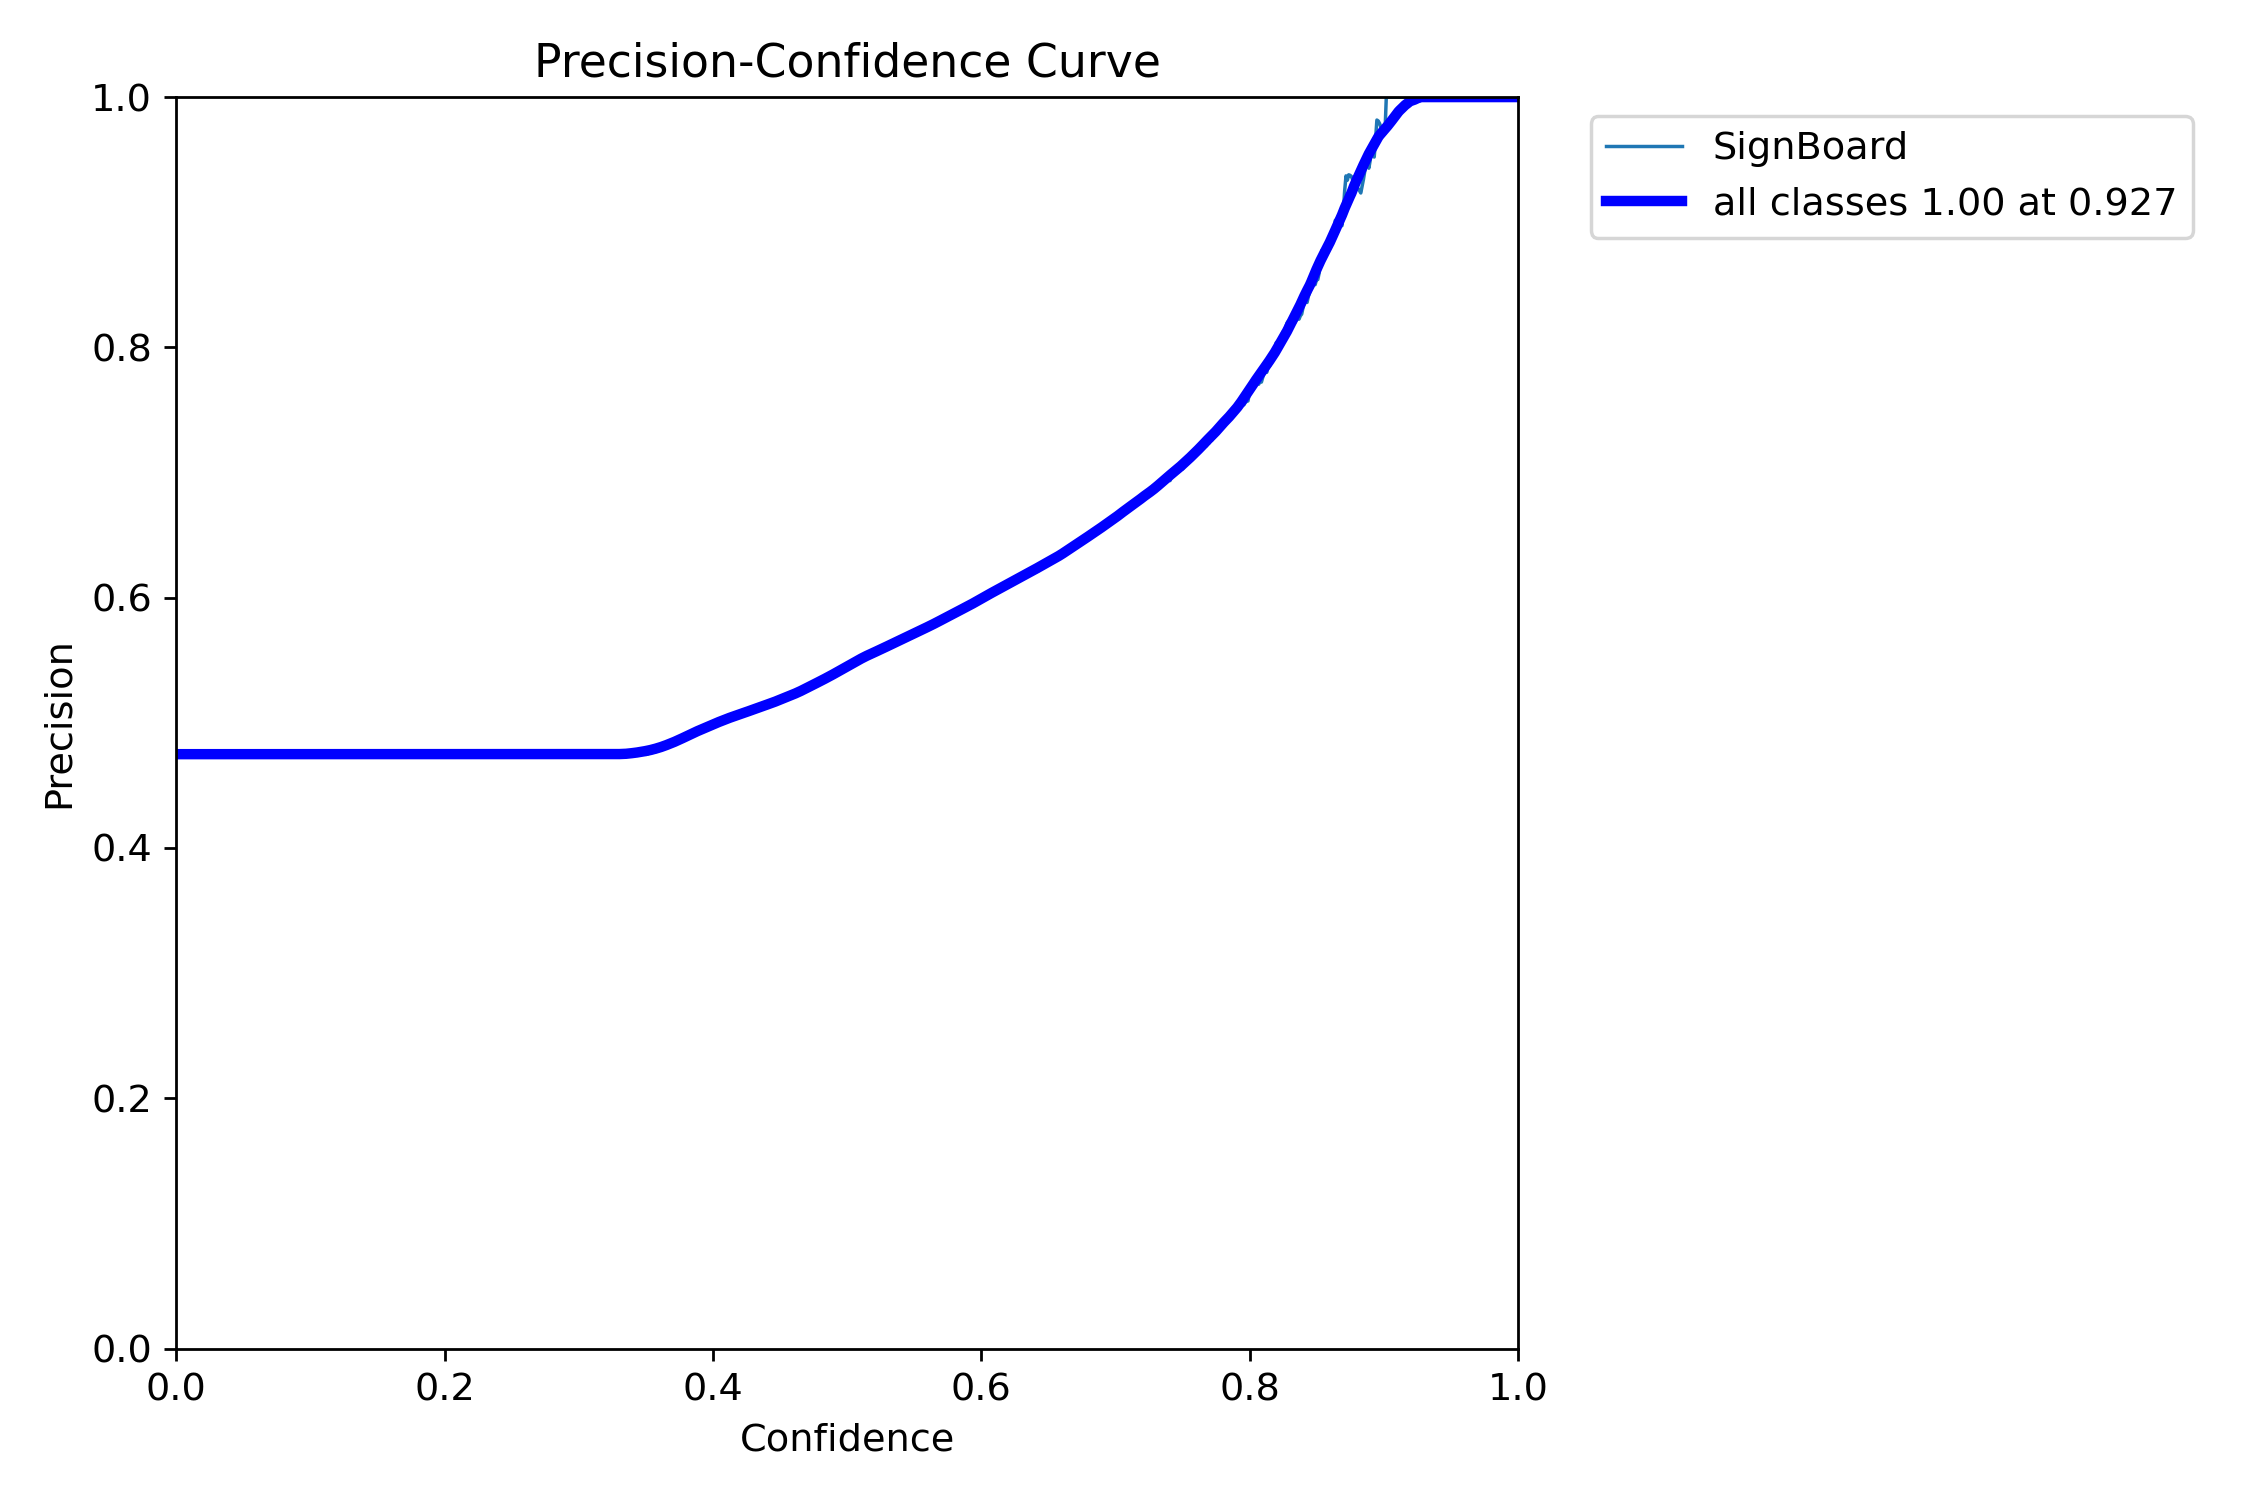

In [ ]:
img_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/val/P_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

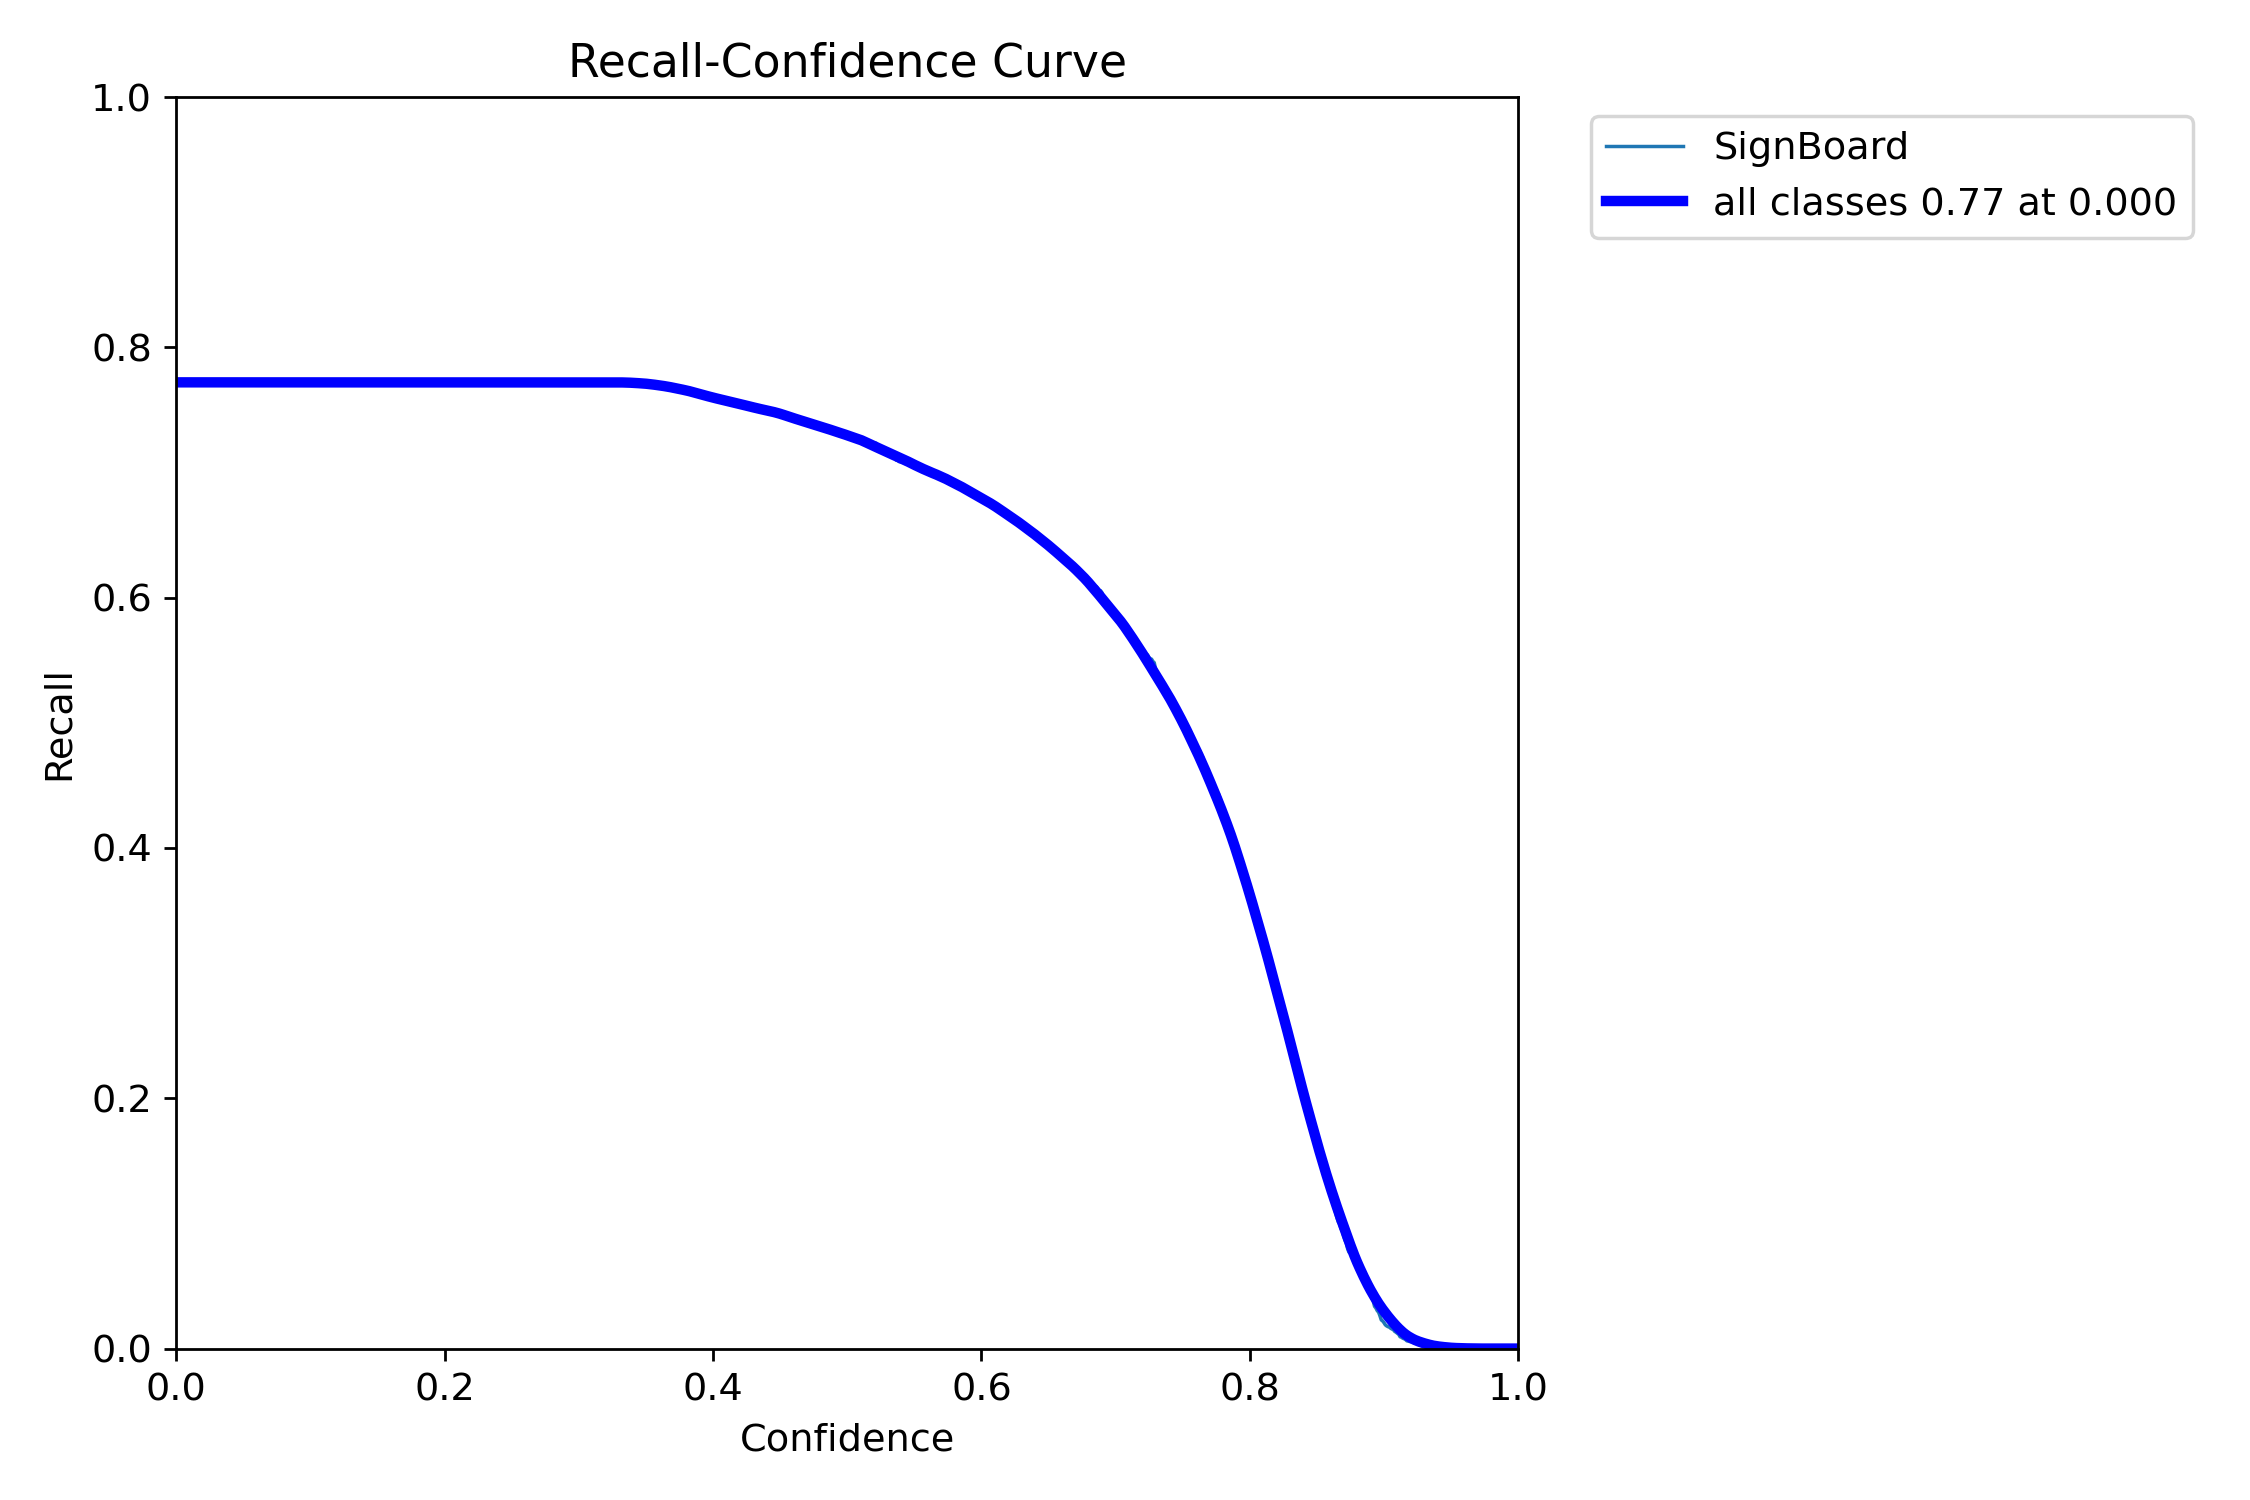

In [ ]:
img_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/val/R_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

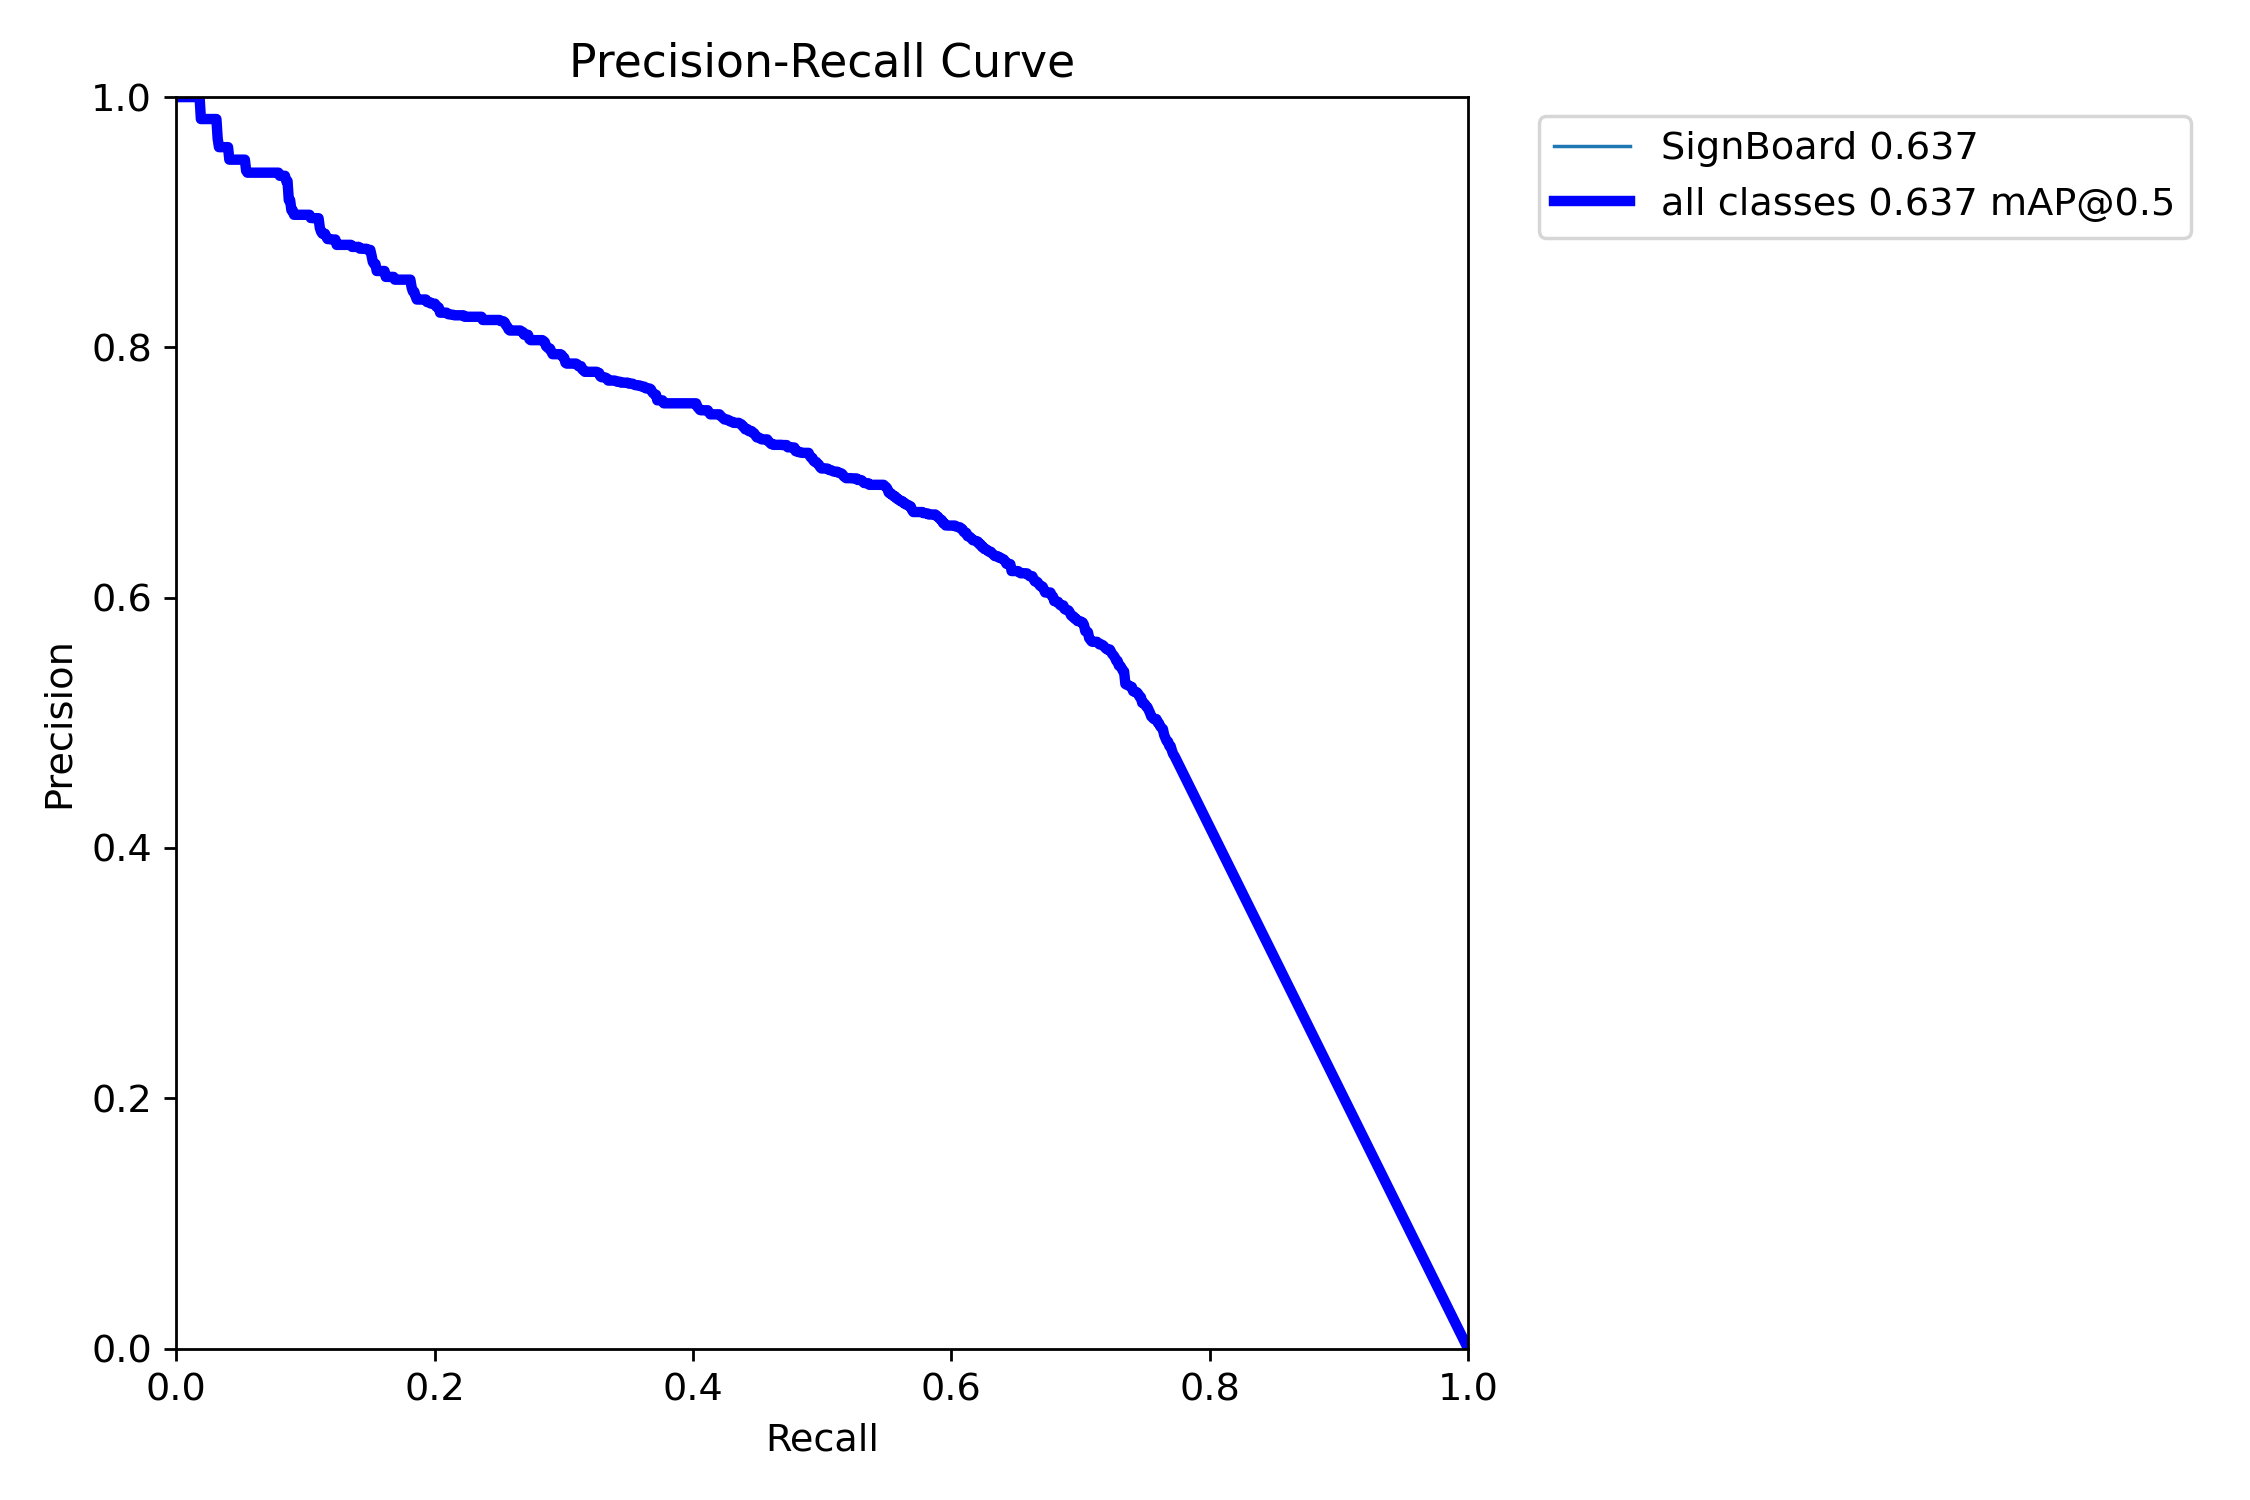

In [ ]:
img_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/val/PR_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

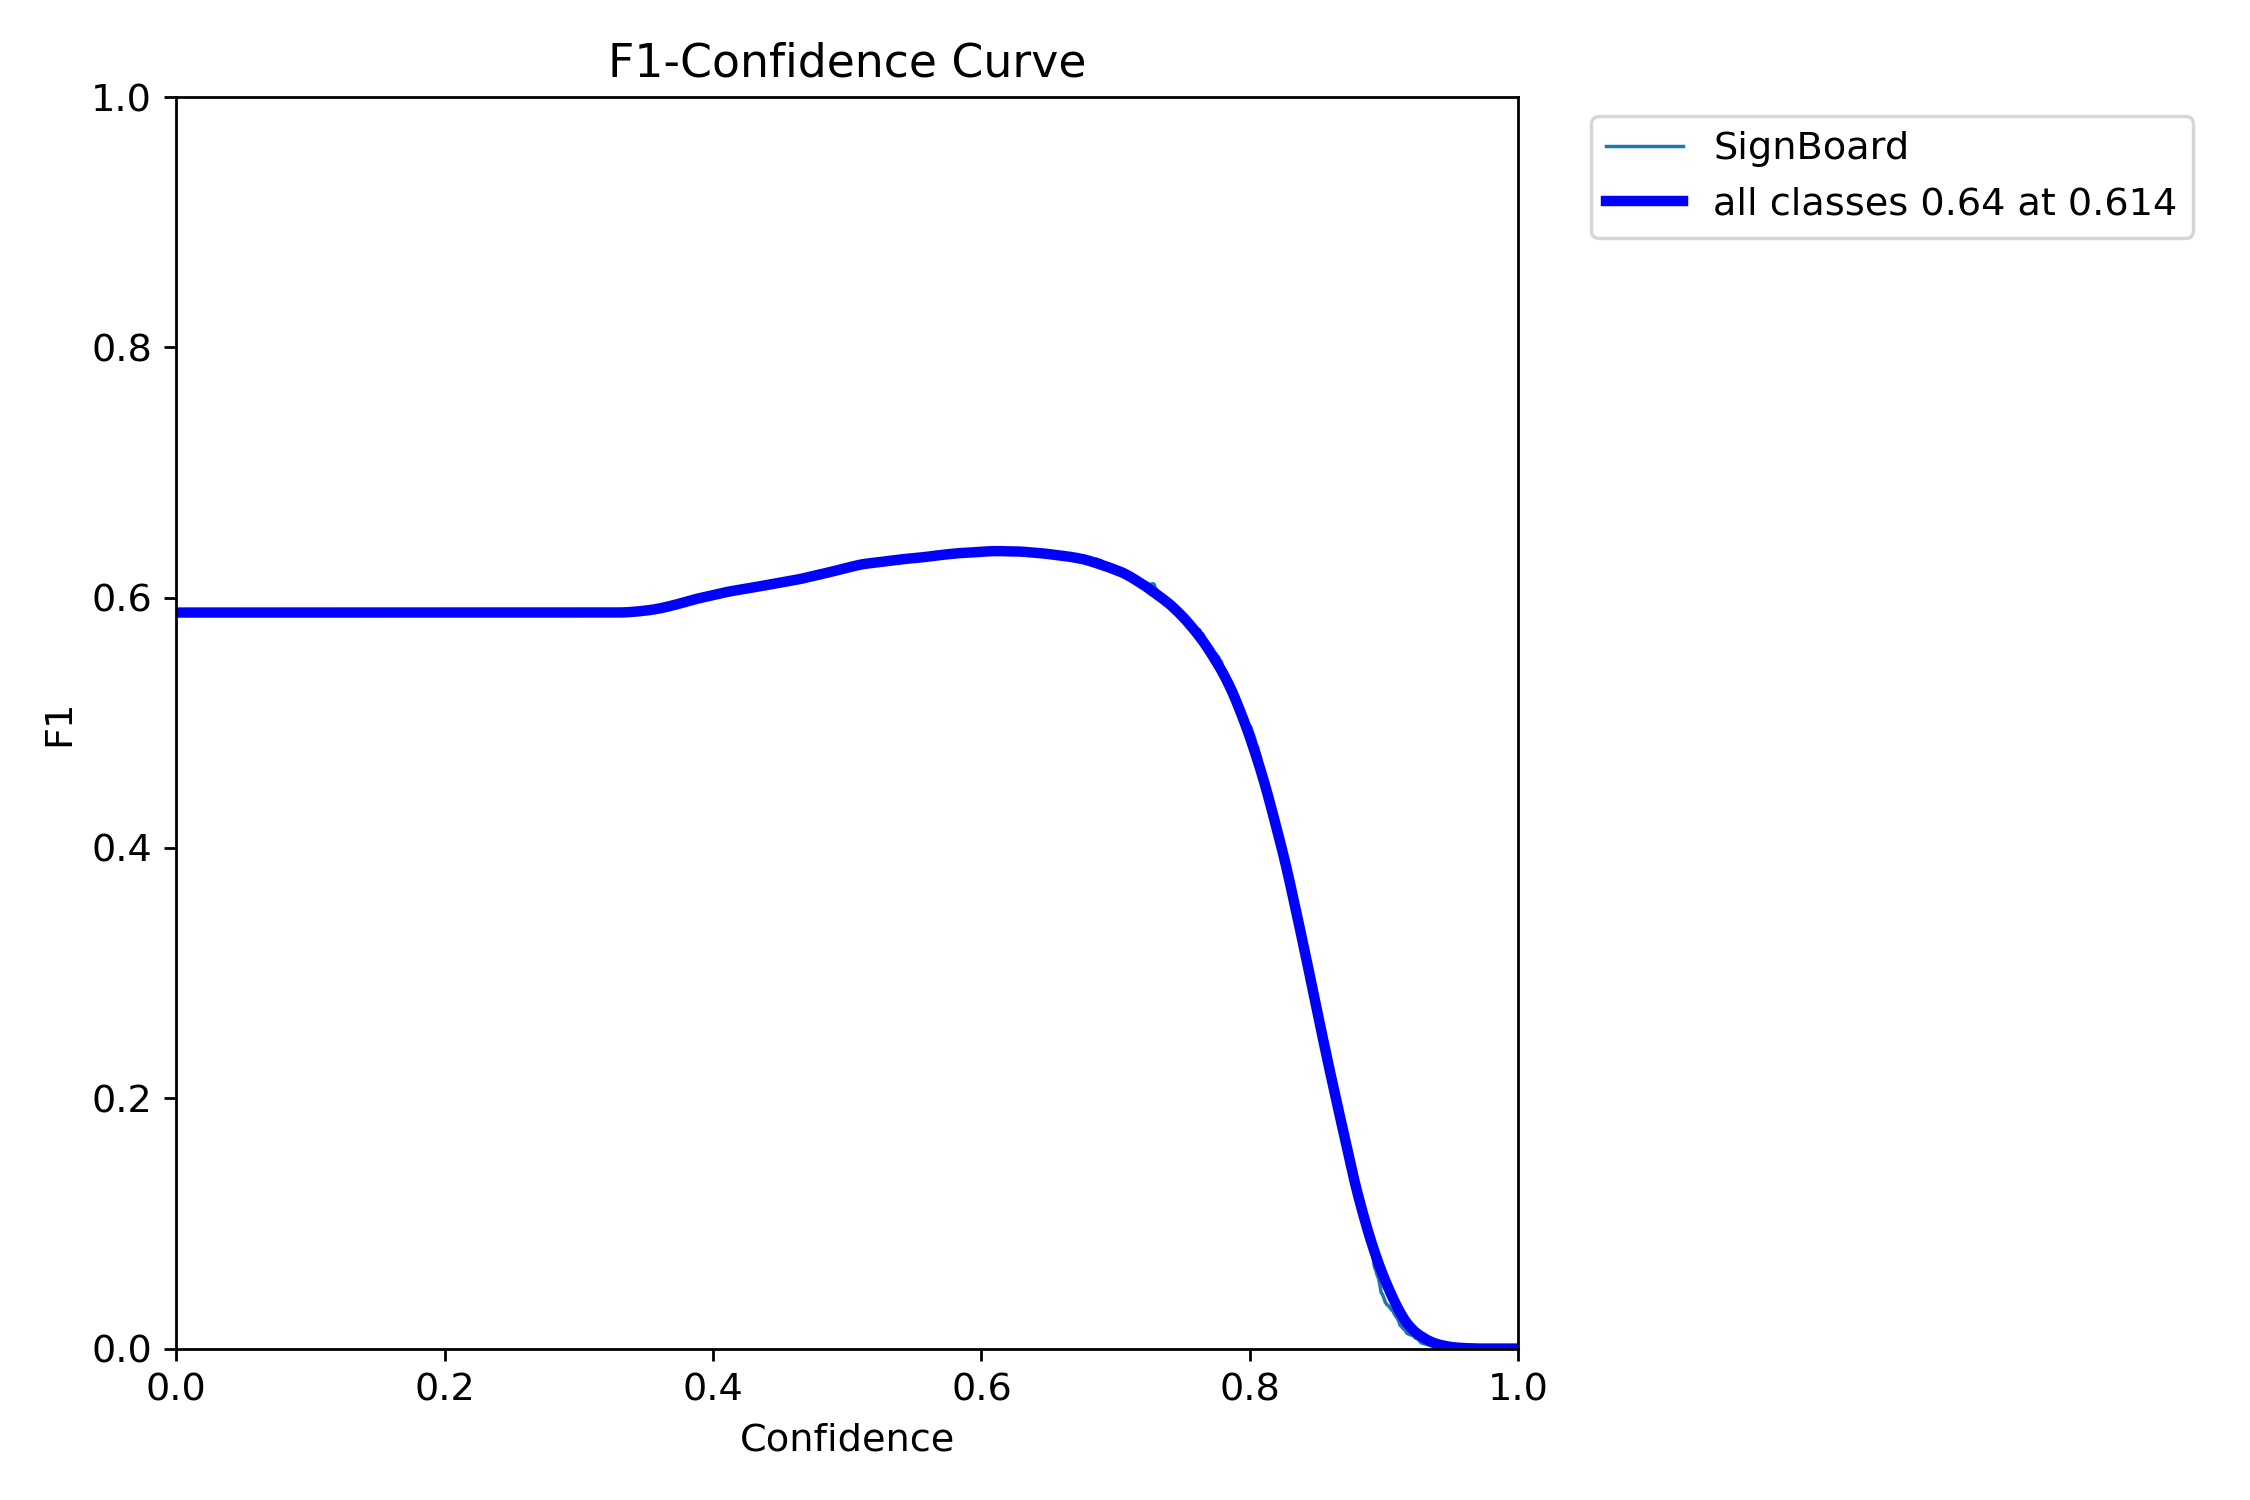

In [ ]:
img_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/val/F1_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

In [ ]:
import json
import pandas as pd
from pathlib import Path
from PIL import Image
import csv

output_dir = 'runs/detect/val'
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, 'scores.csv')

def calculate_iou1(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def load_ground_truth1(image_name, label_dir, w, h):
    label_file = Path(label_dir) / f"{image_name}.txt"
    ground_truths = []
    if label_file.exists():
        with open(label_file, 'r') as file:
            for line in file:
                _, x_center, y_center, width, height = map(float, line.split())
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                ground_truths.append([x1, y1, x2, y2])
    return ground_truths

# Loading predictions from the JSON file
with open('runs/detect/val/predictions.json', 'r') as f:
    predictions = json.load(f)

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Predicted Bbox', 'Confidence', 'Ground Truth Bbox', 'IoU'])

    for pred in predictions:
        img_id = pred['image_id']
        image_path = Path(f"val/images/{img_id}.jpg")
        if not image_path.exists():
            image_path = Path(f"val/images/{img_id}.png")

        if image_path.exists():
            w, h = get_image_dimensions(image_path)
            pred_bbox = pred['bbox']
            conf = pred['score']
            x1, y1 = (pred_bbox[0] - pred_bbox[2] / 2), (pred_bbox[1] - pred_bbox[3] / 2)
            x2, y2 = (pred_bbox[0] + pred_bbox[2] / 2), (pred_bbox[1] + pred_bbox[3] / 2)
            pred_box = [x1, y1, x2, y2]

            ground_truth_bboxes = load_ground_truth1(img_id, 'val/labels', w, h)
            for gtbox in ground_truth_bboxes:
                iou_score = calculate_iou1(pred_box, gtbox)
                writer.writerow([img_id, (x1, y1, x2, y2), conf, gtbox, iou_score])

print(f"Results have been saved to {csv_file}")


Results have been saved to runs/detect/val/scores.csv


In [ ]:
import pandas as pd

csv_file_path = 'runs/detect/val/scores.csv'
df = pd.read_csv(csv_file_path)
df.head(10)


,Image,Predicted Bbox,Confidence,Ground Truth Bbox,IoU
0,21301326_12,"(374.9135, 700.7815, 1987.2585, 1072.1005)",0.79093,"[948, 831, 2812, 1278]",0.212104
1,21301326_12,"(374.9135, 700.7815, 1987.2585, 1072.1005)",0.79093,"[2847, 917, 3663, 1351]",0.000000
2,21301326_12,"(2476.1925, 786.527, 3252.5755, 1135.597)",0.75627,"[948, 831, 2812, 1278]",0.102089
3,21301326_12,"(2476.1925, 786.527, 3252.5755, 1135.597)",0.75627,"[2847, 917, 3663, 1351]",0.165252
4,20101498_19,"(314.6595, 363.2445, 453.77250000000004, 415.4...",0.73828,"[294, 227, 790, 291]",0.000000
5,20101498_19,"(314.6595, 363.2445, 453.77250000000004, 415.4...",0.73828,"[387, 296, 850, 347]",0.000000
6,20101498_19,"(179.99699999999999, 207.04500000000002, 584.0...",0.69787,"[294, 227, 790, 291]",0.242309
7,20101498_19,"(179.99699999999999, 207.04500000000002, 584.0...",0.69787,"[387, 296, 850, 347]",0.000000
8,20101498_19,"(162.07649999999998, 277.3125, 617.40149999999...",0.49313,"[294, 227, 790, 291]",0.092324
9,20101498_19,"(162.07649999999998, 277.3125, 617.40149999999...",0.49313,"[387, 296, 850, 347]",0.160926


# Predictions

In [ ]:
#Testing
from ultralytics import YOLO
model = YOLO('runs/detect/train2/weights/best.pt')
results = model(source='test/images',imgsz=576, conf=0.39, iou=0.5,save=True, save_txt=True)


image 1/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1001.png: 352x576 2 SignBoards, 71.7ms
image 2/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1006.png: 352x576 2 SignBoards, 57.1ms
image 3/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1008.png: 352x576 4 SignBoards, 10.5ms
image 4/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1013.png: 352x576 4 SignBoards, 13.5ms
image 5/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1017.png: 352x576 6 SignBoards, 10.5ms
image 6/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1022.png: 352x576 2 SignBoards, 10.5ms
image 7/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1024.png: 352x576 2 SignBoards, 10.5ms
image 8/377 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/images/1444.png: 352x576 3 SignBoards, 10.5ms
image 9/377 /content/drive/MyDrive/CSE4

In [ ]:
import csv
output_dir = 'runs/detect/predict2'
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, 'testscore.csv')

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Predicted Bbox', 'Confidence', 'Ground Truth Bbox', 'IoU'])

    for result in results:
        img = np.copy(result.orig_img)
        img_name = Path(result.path).stem
        boxes = result.boxes.cpu().numpy()
        xywhs = boxes.xywhn
        confs = boxes.conf

        h, w, _ = img.shape

        ground_truth_bboxes = load_ground_truth(img_name, 'test/labels')

        for xywh, conf in zip(xywhs, confs):
            x1, y1 = int((xywh[0] - xywh[2] / 2) * w), int((xywh[1] - xywh[3] / 2) * h)
            x2, y2 = int((xywh[0] + xywh[2] / 2) * w), int((xywh[1] + xywh[3] / 2) * h)
            pred_box = [x1, y1, x2, y2]

            # Calculate IoU for each ground truth bbox
            for ground_truth_bbox in ground_truth_bboxes:
                iou_score = calculate_iou(pred_box, ground_truth_bbox)
                writer.writerow([img_name, (x1, y1, x2, y2), conf, ground_truth_bbox, iou_score])


In [ ]:
def calculate_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou

def load_ground_truth(image_name, label_dir='train/labels'):
    label_file = Path(label_dir) / f"{image_name}.txt"
    ground_truths = []
    if label_file.exists():
        with open(label_file, 'r') as file:
            for line in file:
                _, x_center, y_center, width, height = map(float, line.split())
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                ground_truths.append([x1, y1, x2, y2])
    return ground_truths

In [ ]:
import pandas as pd

csv_file_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/predict2/testscore.csv'
df = pd.read_csv(csv_file_path)
df.head(10)


,Image,Predicted Bbox,Confidence,Ground Truth Bbox,IoU
0,1001,"(838, 186, 999, 229)",0.664318,"[282, 120, 842, 310]",0.001520
1,1001,"(442, 119, 832, 314)",0.422962,"[282, 120, 842, 310]",0.683895
2,1006,"(381, 178, 777, 315)",0.784587,"[348, 157, 800, 343]",0.645304
3,1006,"(0, 311, 306, 497)",0.752978,"[348, 157, 800, 343]",0.000000
4,1008,"(468, 330, 854, 370)",0.810015,"[239, 335, 853, 368]",0.552463
5,1008,"(468, 330, 854, 370)",0.810015,"[91, 42, 428, 105]",0.000000
6,1008,"(473, 32, 860, 102)",0.608425,"[239, 335, 853, 368]",0.000000
7,1008,"(473, 32, 860, 102)",0.608425,"[91, 42, 428, 105]",0.000000
8,1008,"(87, 42, 425, 95)",0.580166,"[239, 335, 853, 368]",0.000000
9,1008,"(87, 42, 425, 95)",0.580166,"[91, 42, 428, 105]",0.825537


In [ ]:
import cv2
from PIL import Image
def resize_image(img, width):
    height, width = img.shape[:2]
    new_height = 900
    return cv2.resize(img, (900, new_height))

random_indices = random.sample(range(363), 8)
for i in random_indices:
    plot=results[i].plot()
    plot=cv2.cvtColor(plot,cv2.COLOR_BGR2RGB)
    resized_plot = resize_image(plot, 600)
    display(Image.fromarray(resized_plot))

Output hidden; open in https://colab.research.google.com to view.

# Corresponding label and image mapping

In [ ]:
import os
import pandas as pd


text_files_directory = 'runs/detect/predict2/labels'


image_ids = []
text_file_ids = []

for filename in os.listdir(text_files_directory):
    if filename.endswith('.txt'):
        image_id = filename.split('.')[0]
        text_file_id = filename
        image_ids.append(image_id + '.jpg' if image_id.endswith('.jpg') else image_id + '.png')
        text_file_ids.append(text_file_id)

# Creating a DataFrame from the lists
df = pd.DataFrame({'ImageID': image_ids, 'TextFileID': text_file_ids})


output_directory = 'runs/detect/predict2/scores'
os.makedirs(output_directory, exist_ok=True)
csv_file_path = os.path.join(output_directory, 'image_text_file_mapping.csv')

# Saving the DataFrame as a CSV file
df.to_csv(csv_file_path, index=False)

# Displaying the DataFrame (optional)
print(df)

       ImageID TextFileID
0     1001.png   1001.txt
1     1006.png   1006.txt
2     1008.png   1008.txt
3     1013.png   1013.txt
4     1017.png   1017.txt
..         ...        ...
367  ID_07.png  ID_07.txt
368  ID_08.png  ID_08.txt
369  ID_09.png  ID_09.txt
370  ID_18.png  ID_18.txt
371  ID_23.png  ID_23.txt

[372 rows x 2 columns]


In [ ]:
%%writefile customtestdata.yaml
train: C:\Users\ASUS\section2-group1\train\images
val: test/images

nc: 1

# class names
names:
  0: 'SignBoard'


Overwriting customtestdata.yaml


In [ ]:
from ultralytics import YOLO
model = YOLO('runs/detect/train2/weights/best.pt')
results = model.val(data='/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/customtestdata.yaml',imgsz=544,batch=1,conf=0.3,iou=0.5, save_json=True,plots=True)

Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/test/labels.cache... 377 images, 2 backgrounds, 0 corrupt: 100%|██████████| 377/377 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 377/377 [01:17<00:00,  4.85it/s]


                   all        377        872      0.612       0.67      0.648      0.439
Speed: 0.6ms preprocess, 55.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Saving runs/detect/val4/predictions.json...
Results saved to runs/detect/val4


In [ ]:
%cd /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1

/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1


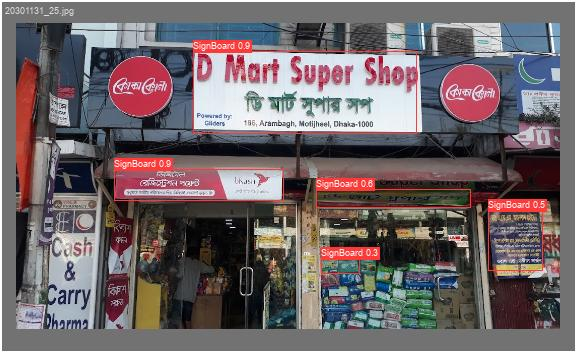

In [ ]:
from IPython.display import Image

img_path = 'runs/detect/val4/val_batch0_pred.jpg'

# Display the image
Image(img_path)

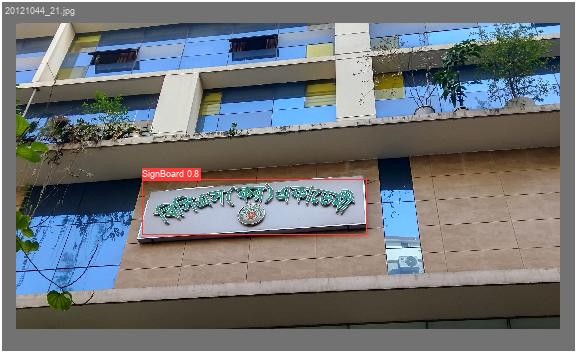

In [ ]:
img_path = 'runs/detect/val4/val_batch1_pred.jpg'

# Display the image
Image(img_path)

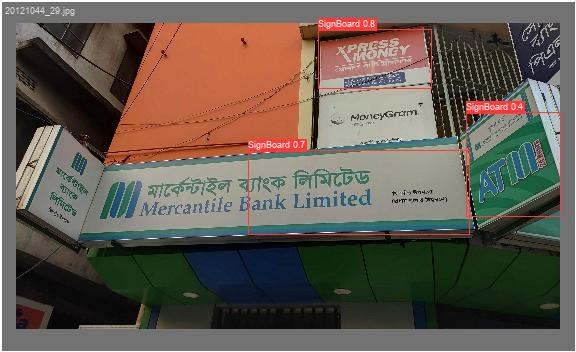

In [ ]:
img_path = 'runs/detect/val4/val_batch2_pred.jpg'

# Display the image
Image(img_path)

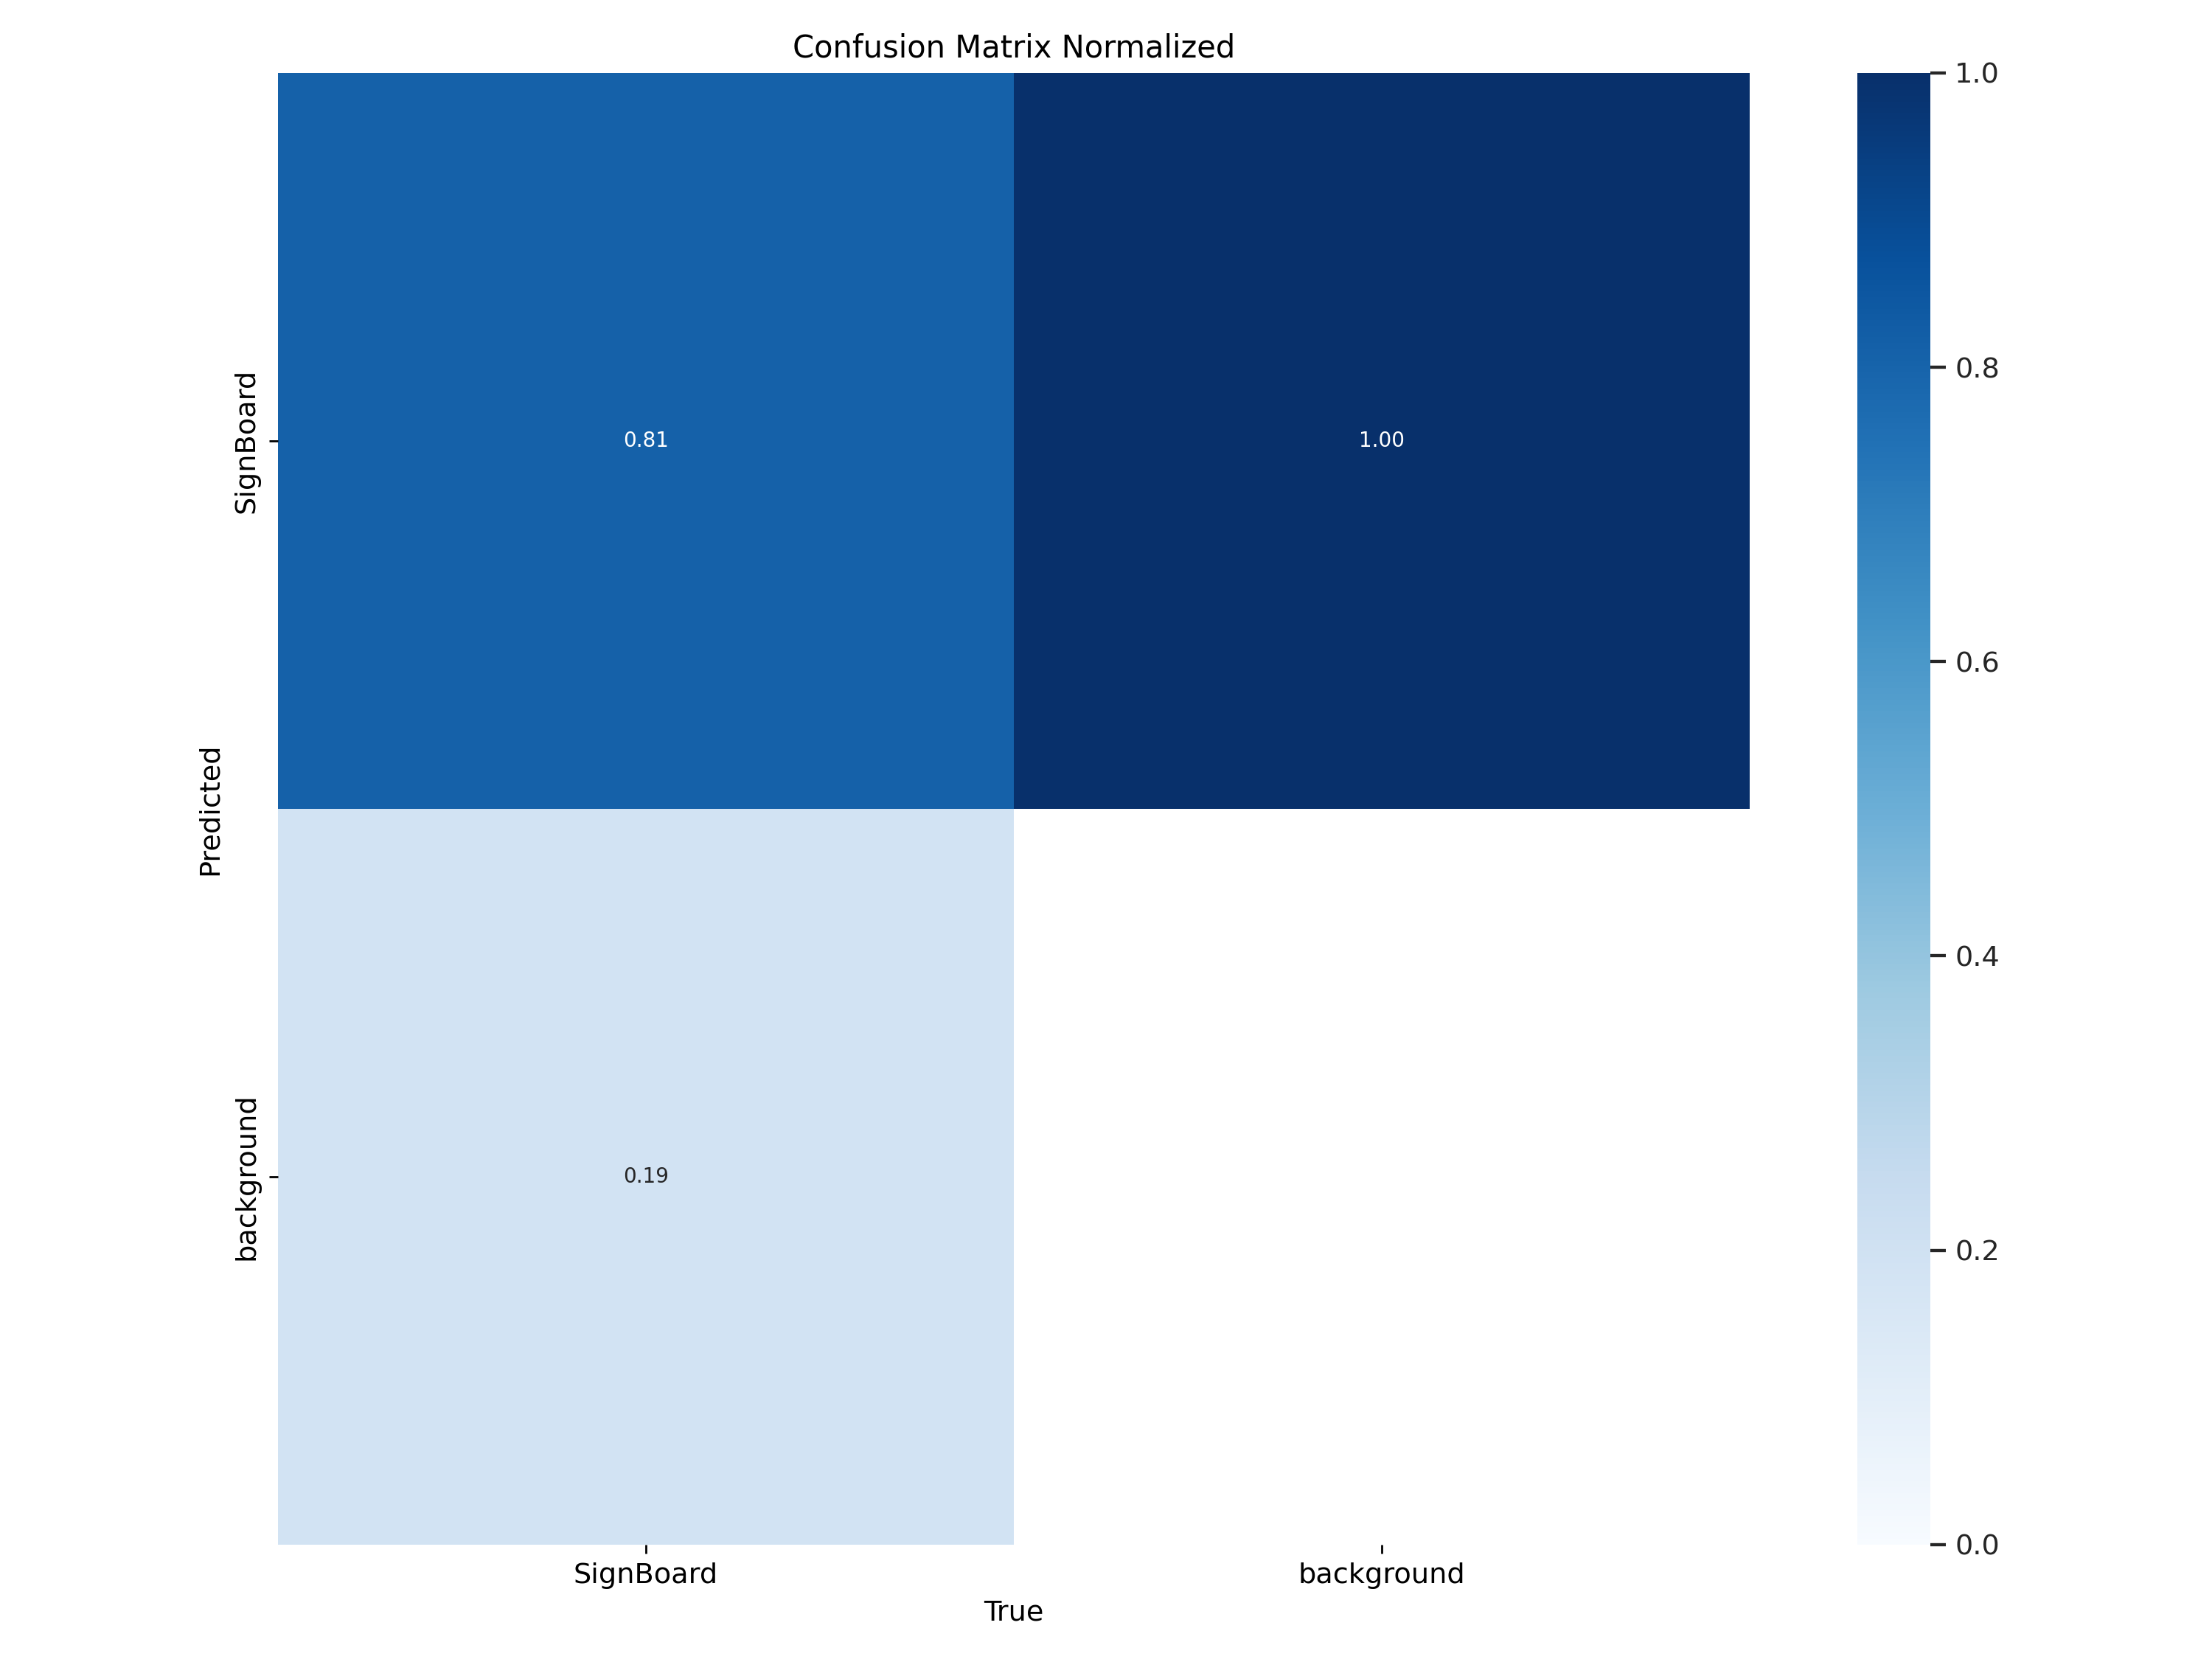

In [ ]:
img_path = '/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/runs/detect/val4/confusion_matrix_normalized.png'

# Display the image
Image(filename=img_path,width=600,height=600)

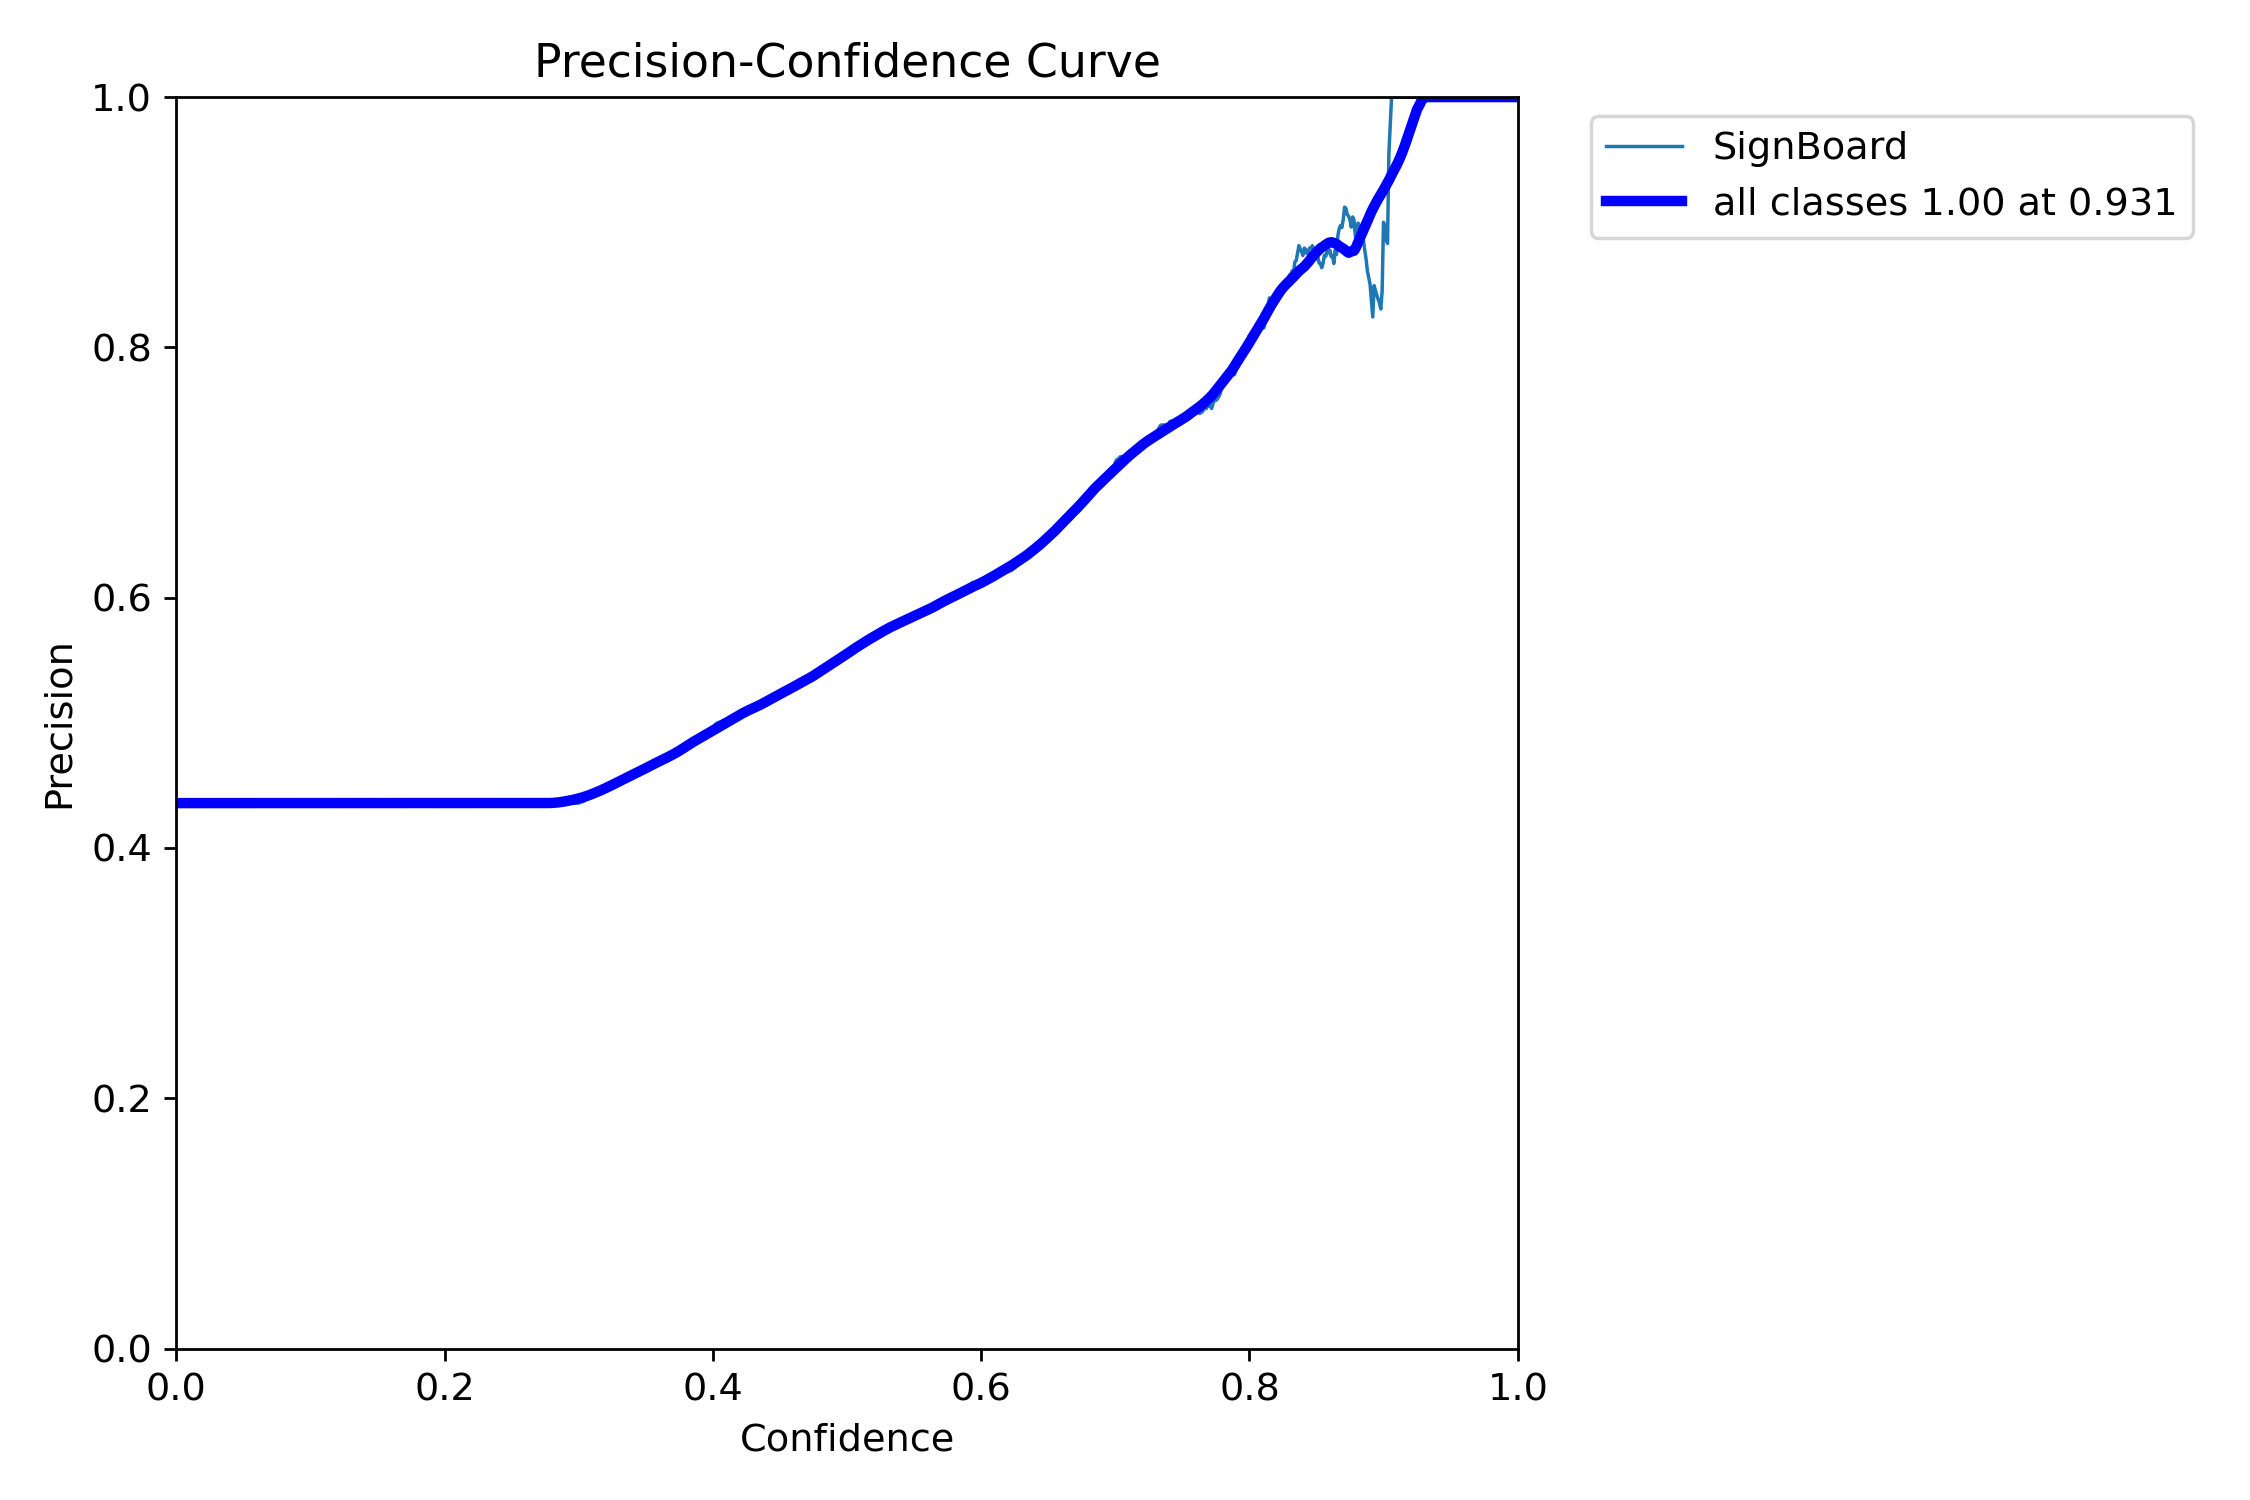

In [ ]:
img_path = 'runs/detect/val4/P_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)


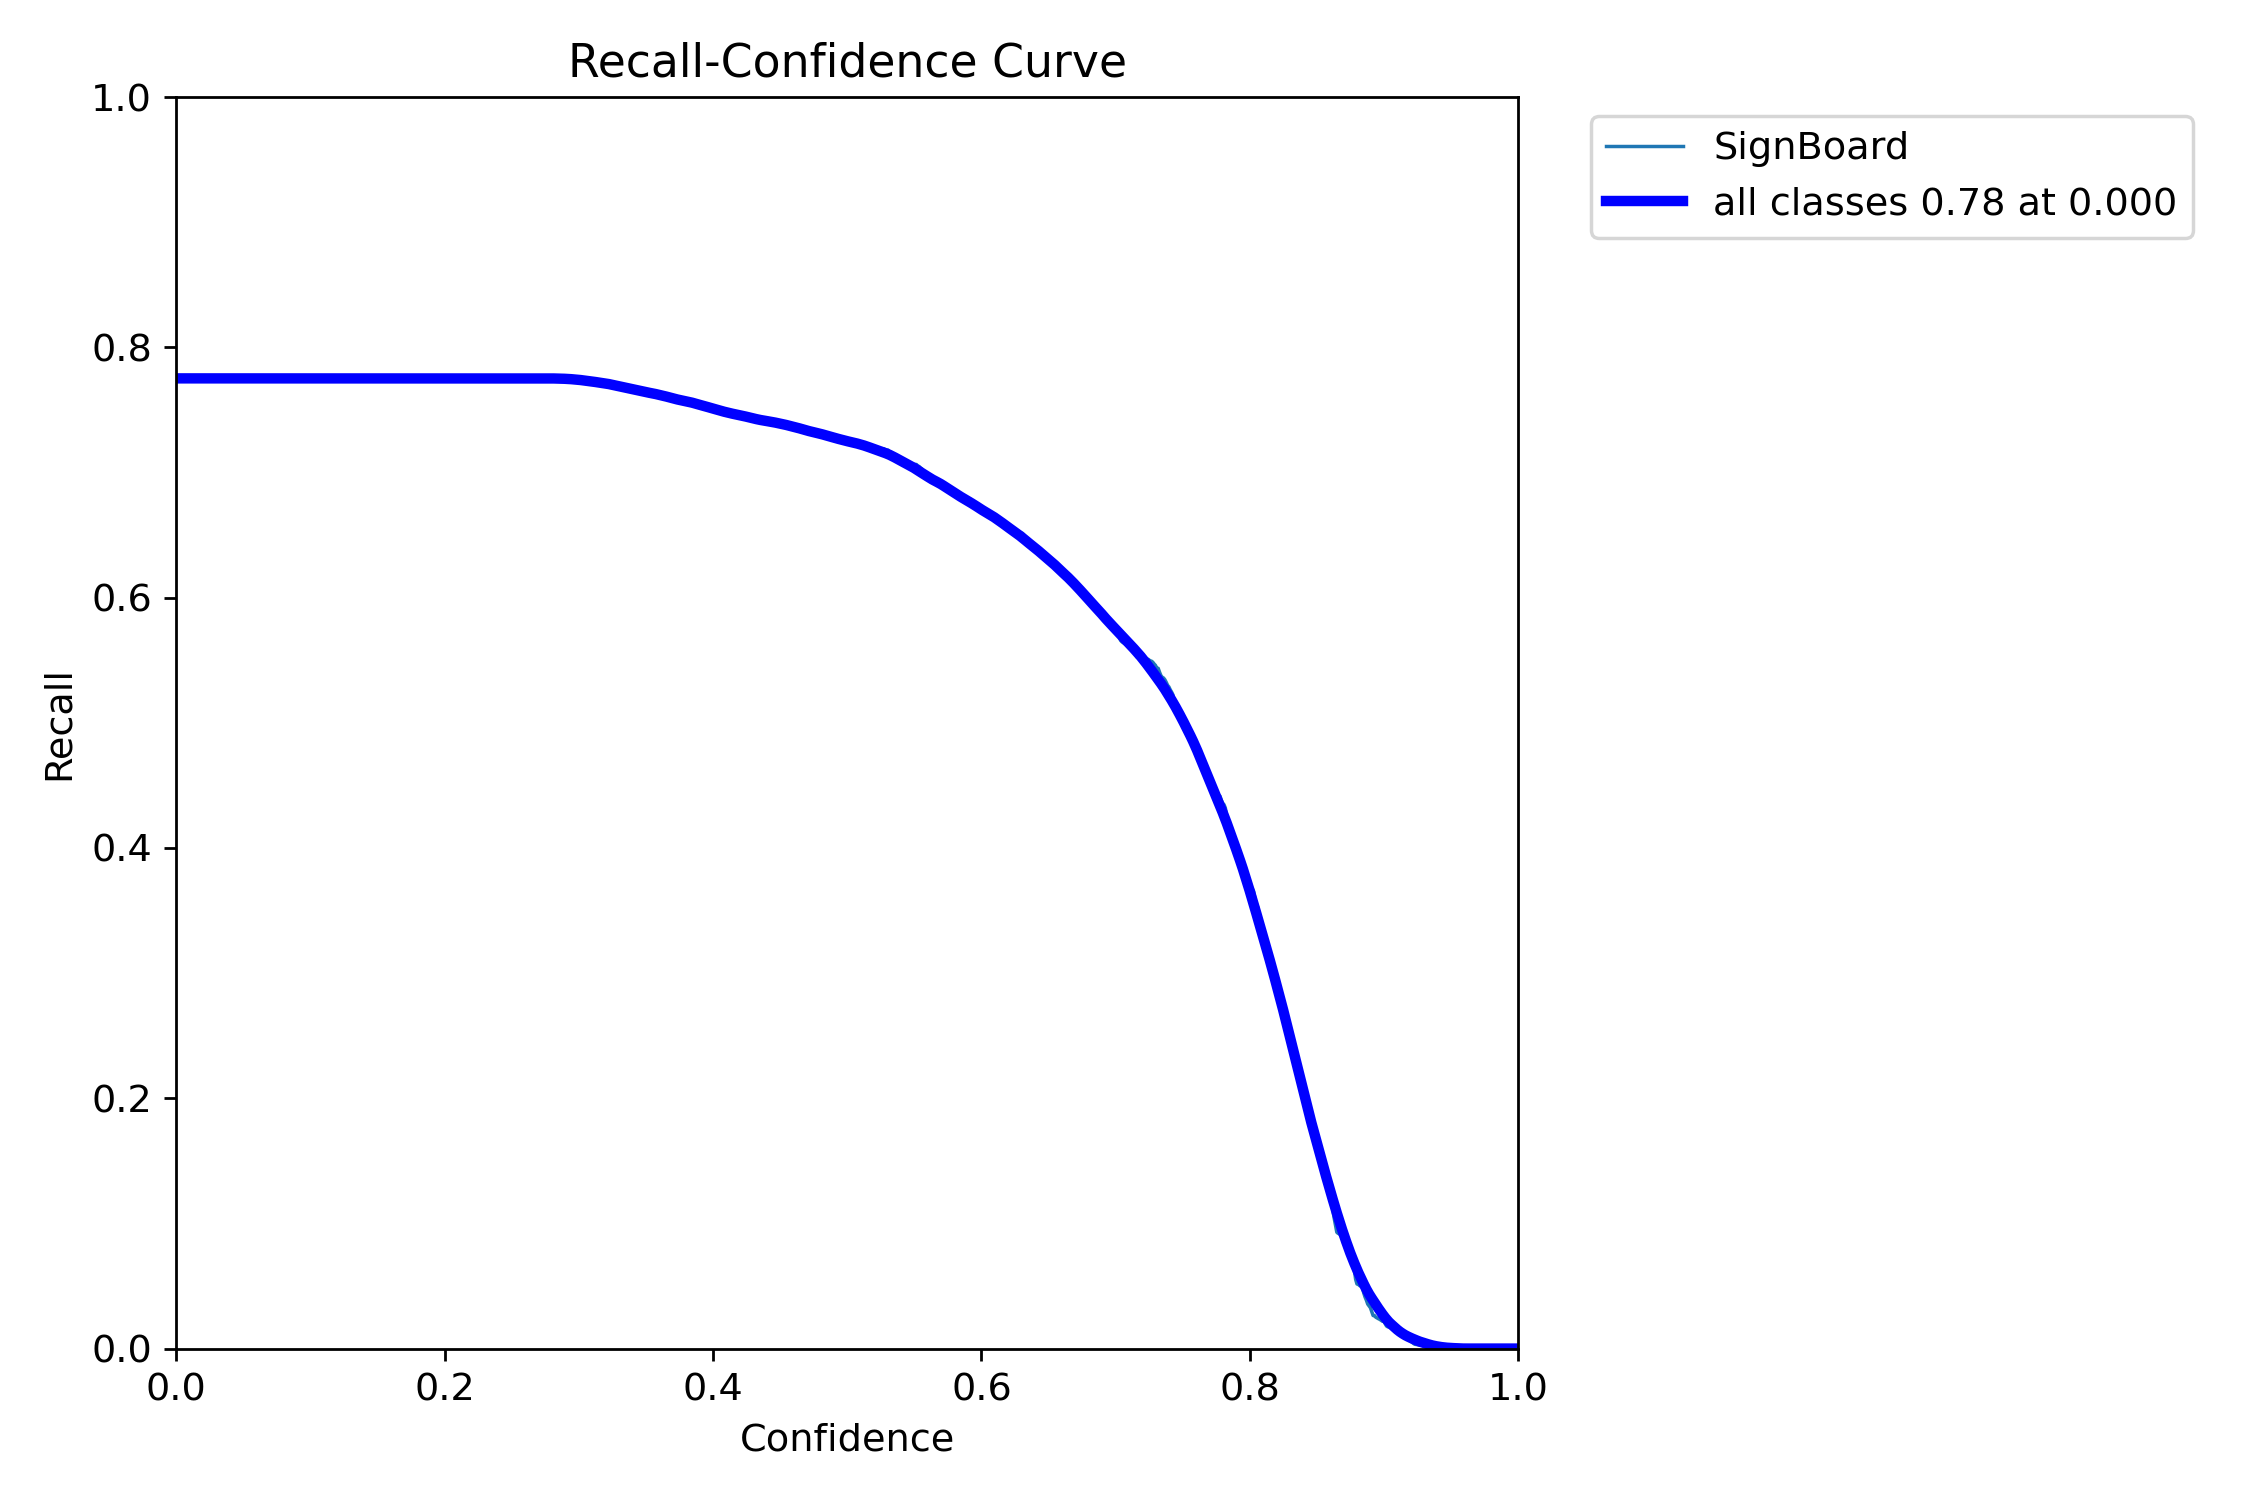

In [ ]:
img_path = 'runs/detect/val4/R_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

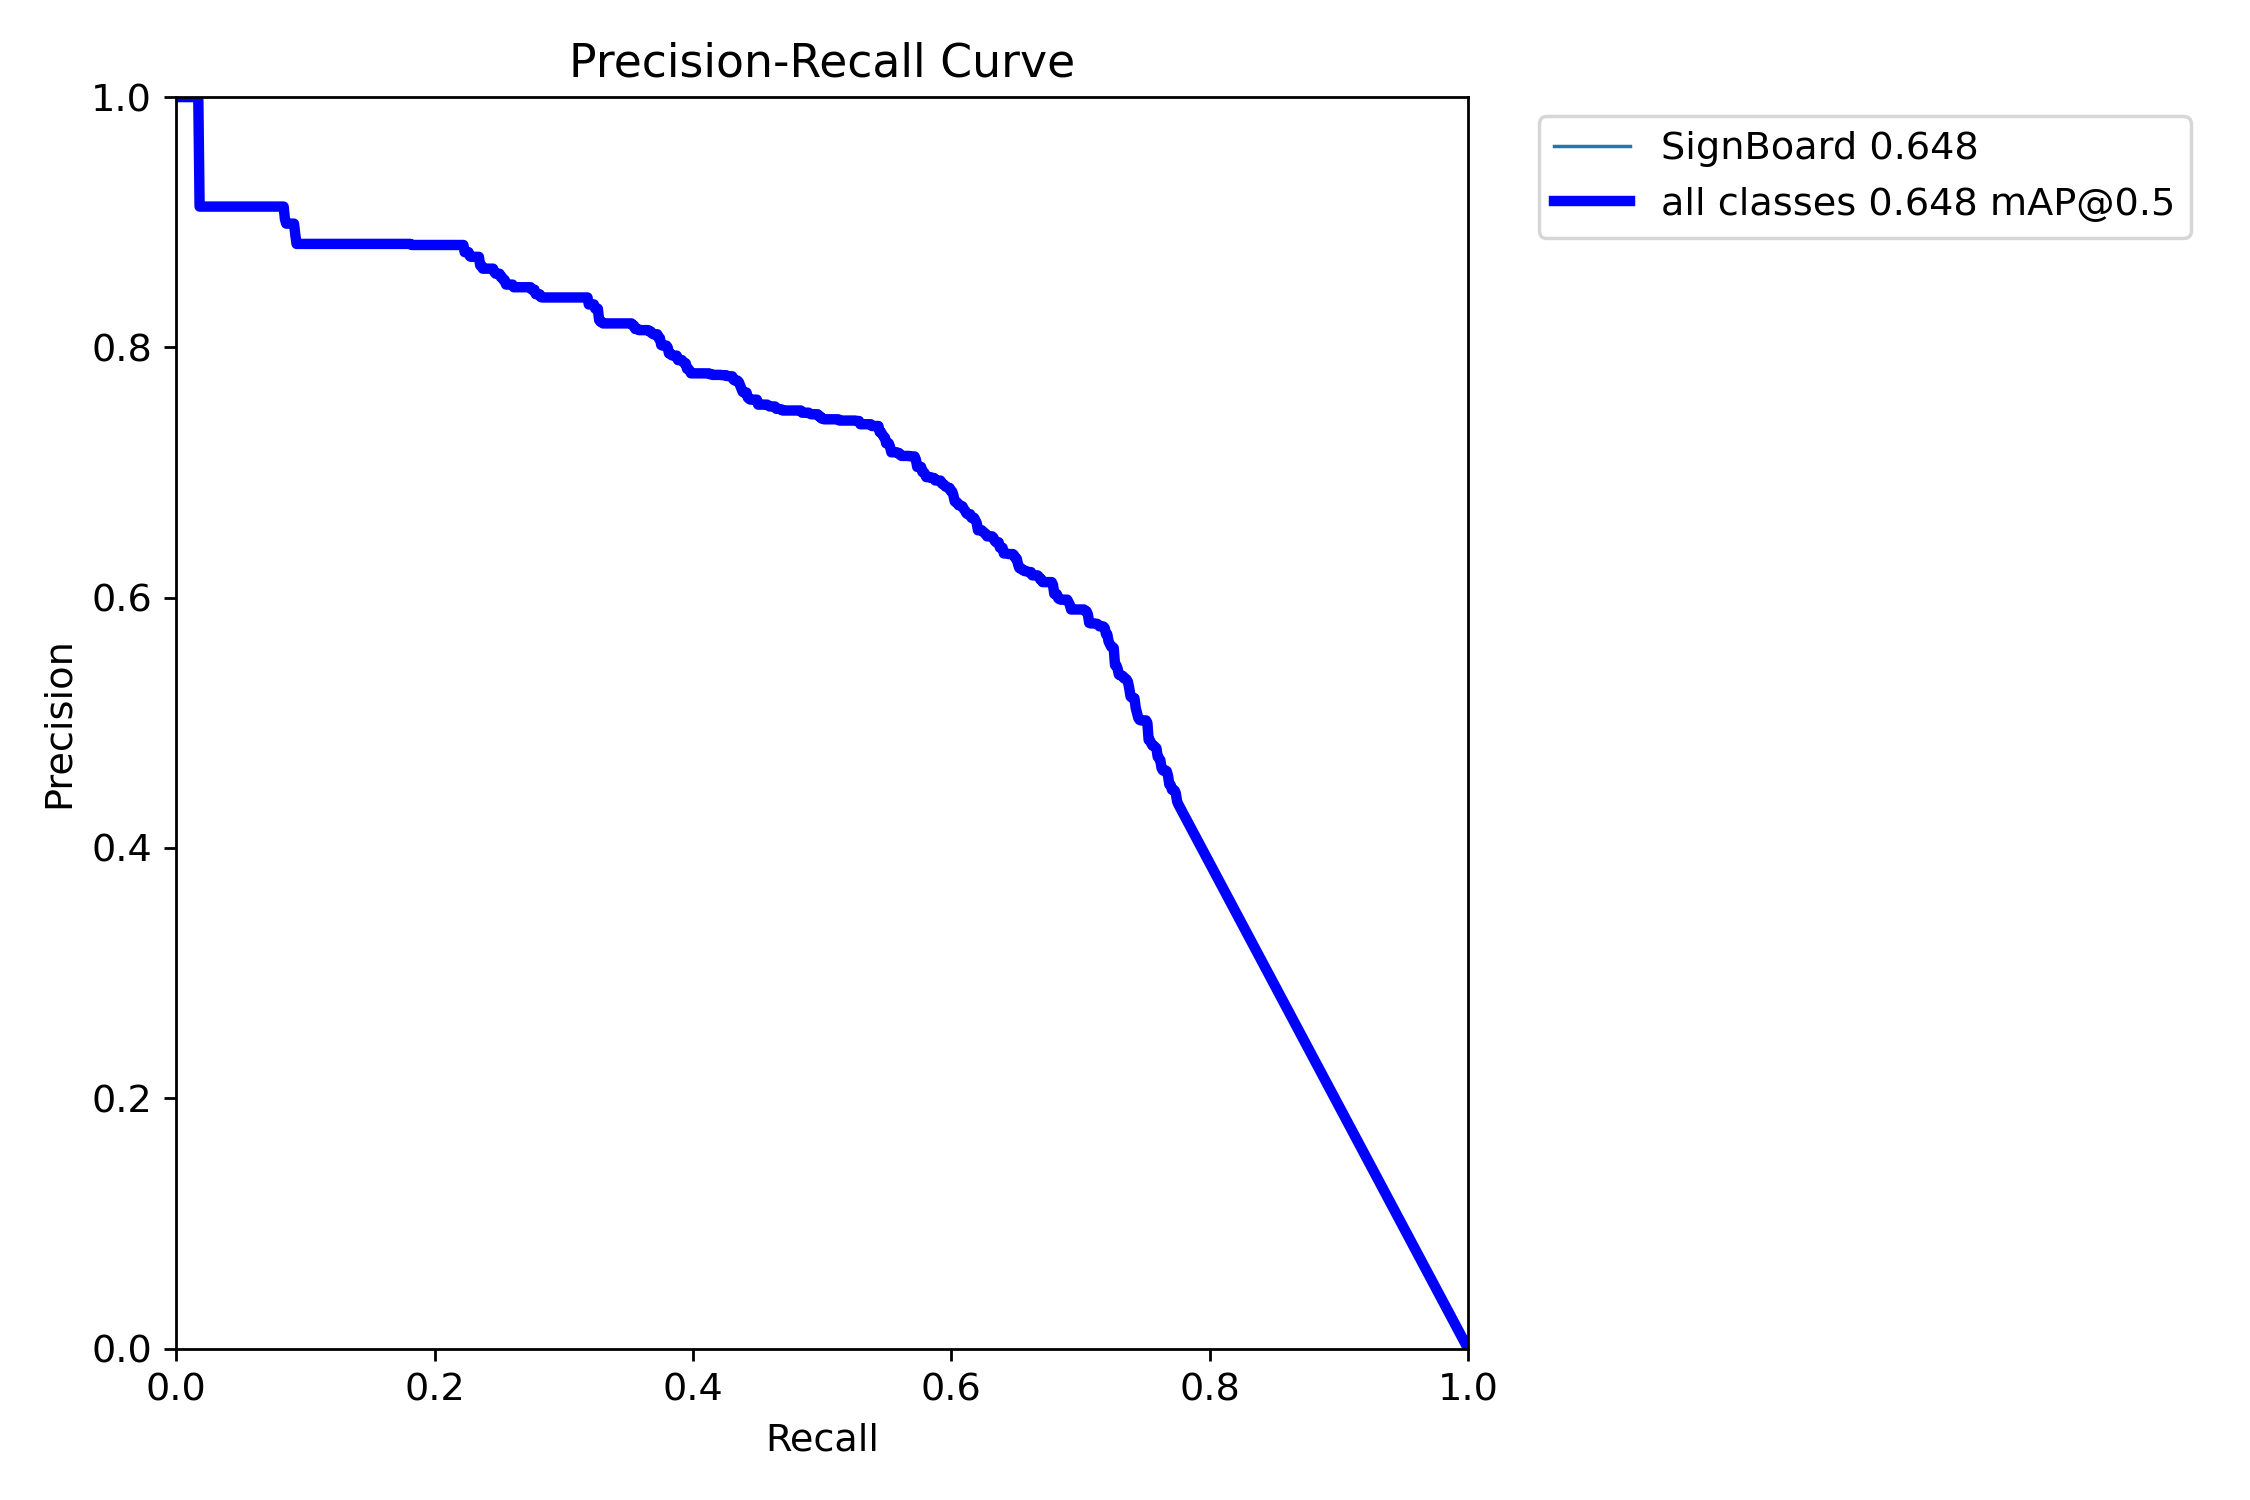

In [ ]:
img_path = 'runs/detect/val4/PR_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

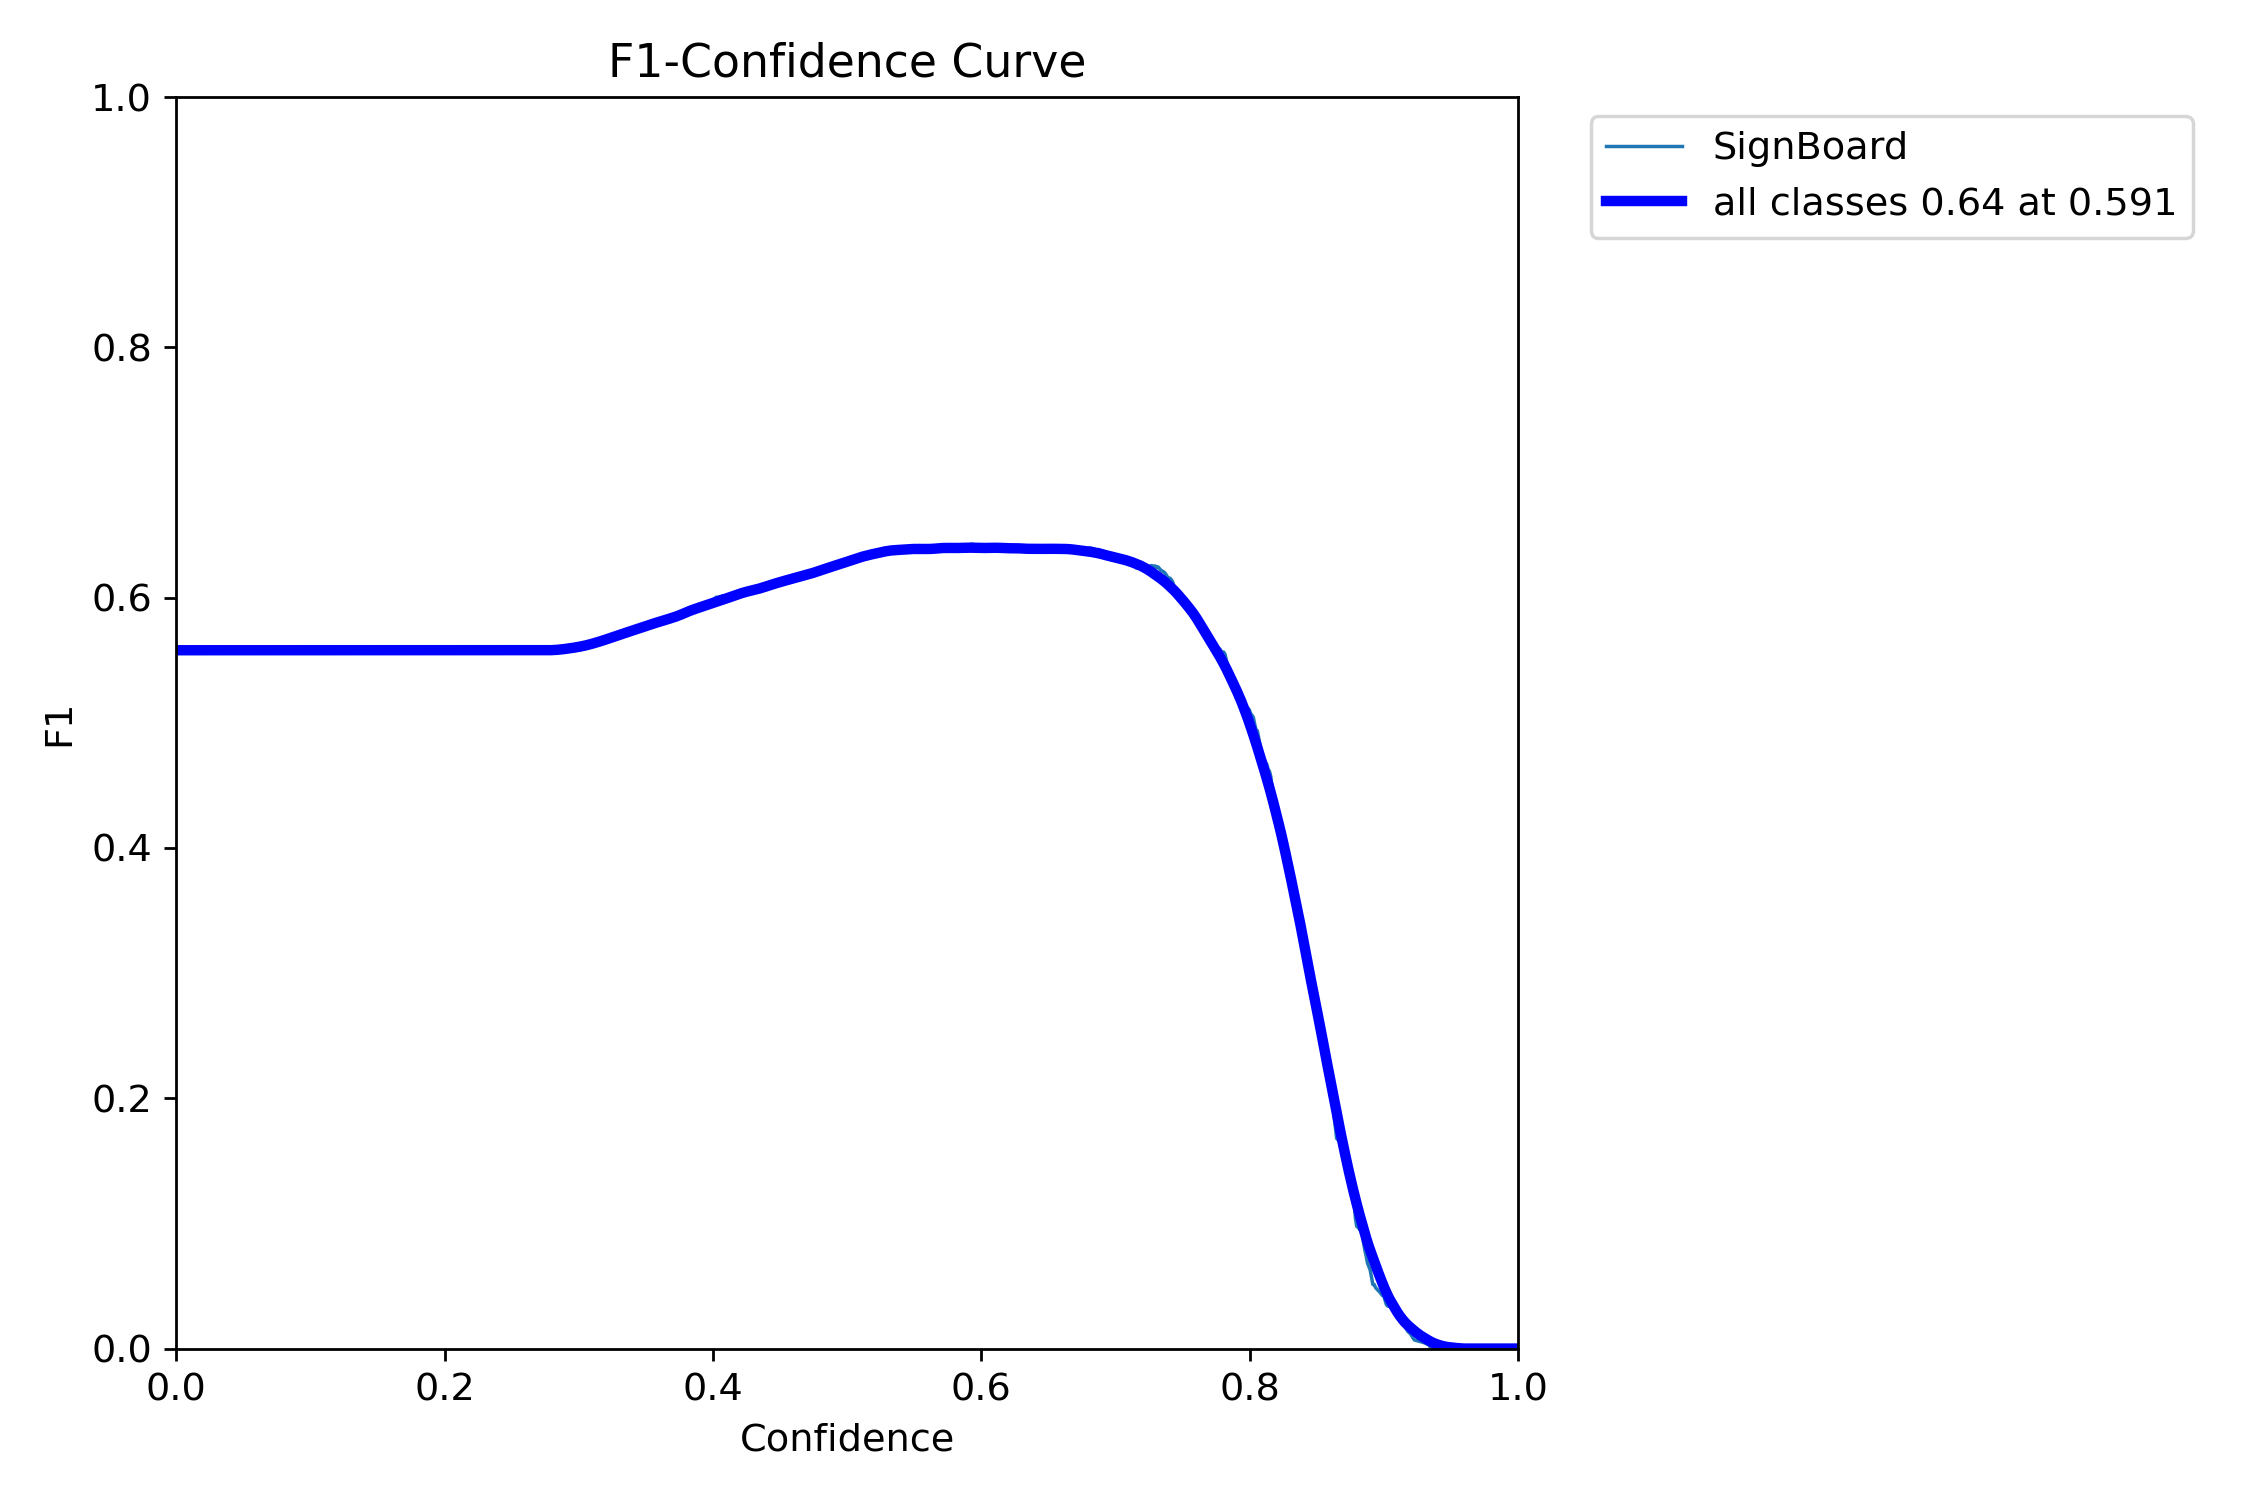

In [ ]:
img_path = 'runs/detect/val4/F1_curve.png'

# Display the image
Image(filename=img_path,width=600,height=600)

In [ ]:

with open('runs/detect/val4/predictions.json') as f:
    df = pd.read_json(f)

# Define the directory path where you want to store the CSV file
output_directory = 'runs/detect/val4'
os.makedirs(output_directory, exist_ok=True)
csv_file_path = os.path.join(output_directory, 'validation_results.csv')
df.to_csv(csv_file_path, index=False)
df.to_csv('validation_results.csv', index=False)

# Random Testing

In [ ]:
#Testing
from ultralytics import YOLO
model = YOLO('runs/detect/train2/weights/best.pt')
results = model(source='testing1',imgsz=928, conf=0.3, iou=0.5,save=True, save_txt=True)


image 1/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/1.jpg: 576x928 11 SignBoards, 84.8ms
image 2/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/139458_130.jpg: 576x928 2 SignBoards, 20.2ms
image 3/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/2.jpg: 576x928 8 SignBoards, 20.1ms
image 4/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/3.jpg: 576x928 4 SignBoards, 20.1ms
image 5/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/4.jpg: 576x928 5 SignBoards, 20.1ms
image 6/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/5.jpg: 576x928 (no detections), 20.1ms
image 7/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/6-ezgif.com-webp-to-jpg-converter.jpg: 576x928 1 SignBoard, 20.1ms
image 8/52 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing1/Screenshot (368).jpg: 416x928 3 SignBoards, 87.2ms
image 9/52 /content/drive/MyDrive/CS

# Testing for Lab Demonstration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1"

/content/drive/MyDrive/CSE428/Milestone2/Section2-Group1


In [4]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.2/755.2 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [9]:
#Testing
from ultralytics import YOLO
model = YOLO('runs/detect/train2/weights/best.pt')
results = model(source='testing2',imgsz=928, conf=0.25, iou=0.5,save=True, save_txt=True)


image 1/6 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing2/1.png: 768x928 3 SignBoards, 26.3ms
image 2/6 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing2/2.png: 512x928 3 SignBoards, 17.5ms
image 3/6 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing2/3.png: 512x928 7 SignBoards, 16.9ms
image 4/6 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing2/4.png: 512x928 1 SignBoard, 16.8ms
image 5/6 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing2/5.png: 544x928 4 SignBoards, 20.0ms
image 6/6 /content/drive/MyDrive/CSE428/Milestone2/Section2-Group1/testing2/6.png: 544x928 (no detections), 19.2ms
Speed: 3.6ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 928)
Results saved to runs/detect/predict5
5 labels saved to runs/detect/predict5/labels


In [10]:
import cv2
from PIL import Image
def resize_image(img, width):
    height, width = img.shape[:2]
    new_height = 900
    return cv2.resize(img, (900, new_height))

# random_indices = random.sample(range(363), 8)
for i in range(6):
    plot=results[i].plot()
    plot=cv2.cvtColor(plot,cv2.COLOR_BGR2RGB)
    resized_plot = resize_image(plot, 600)
    display(Image.fromarray(resized_plot))

Output hidden; open in https://colab.research.google.com to view.